# Using multilayer perceptrons to approximate the solution of partial differential equations

## Import libraries

In [1]:
from pdeUtils import TrialFunctionDataBasedLearning, TrialFunctionResidualBasedLearning, PureNetworkLearning, CustomFunctionLearning, SimpleMLP
from visuals import plot_field_and_error
import matplotlib.pyplot as plt
from matplotlib import cm
import autograd.numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

## Load the data

In [2]:
# define data path
fullDataPath = "./fullRawData/"
internalDataPath = "./internalRawData/"
fieldName25 = "A25.dat"
fieldName50 = "A50.dat"
fieldName100 = "A100.dat"

# skip column 2 - z is constant (2D)
colNames = ["x", "y", "z", "A"]
columns = [0, 1, 3]

# read full numerical solution (interal field + boundaries)
field25 = pd.read_csv(fullDataPath + fieldName25, sep='\t', names=colNames, header=0, usecols=columns)
field50 = pd.read_csv(fullDataPath + fieldName50, sep='\t', names=colNames, header=0, usecols=columns)
field100 = pd.read_csv(fullDataPath + fieldName100, sep='\t', names=colNames, header=0, usecols=columns)

# read numerical solution only for internal points
intField50 = pd.read_csv(internalDataPath + fieldName50, sep='\t', names=colNames, header=0, usecols=columns)
intField100 = pd.read_csv(internalDataPath + fieldName100, sep='\t', names=colNames, header=0, usecols=columns)
intField100.tail()

,x,y,A
9995,0.955,0.995,0.001700
9996,0.965,0.995,0.001311
9997,0.975,0.995,0.000930
9998,0.985,0.995,0.000556
9999,0.995,0.995,0.000185


## Visualize numerical/training data

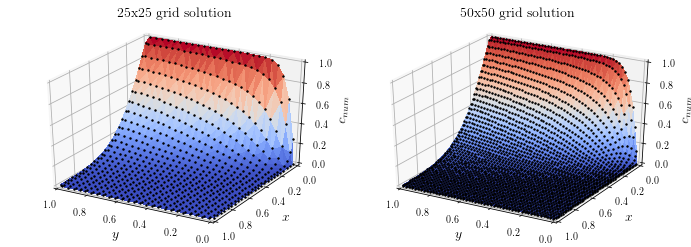

In [4]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_trisurf(field25.y, field25.x, field25.A, cmap=cm.coolwarm, linewidth=0.0, antialiased=False)
ax1.scatter(field25.y, field25.x, field25.A, s=2, c='k', depthshade=False)
ax1.set_title(r'25x25 grid solution')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_trisurf(field50.y, field50.x, field50.A, cmap=cm.coolwarm, linewidth=0.0, antialiased=False)
ax2.scatter(field50.y, field50.x, field50.A, s=2, c='k', depthshade=False)
ax2.set_title(r'50x50 grid solution')

x_domain = [0.0, 1.0]
y_domain = [0.0, 1.0]

for ax in [ax1, ax2]:
    ax.set_xlim(y_domain[0], y_domain[1])
    ax.set_ylim(x_domain[0], x_domain[1])
    ax.set_zlim(0, 1)
    ax.view_init(30, 120)
    ax.set_xlabel(r"$y$")
    ax.set_ylabel(r"$x$")
    ax.set_zlabel(r"$c_{num}$")
fig.subplots_adjust(wspace=0.05, hspace=0)
fig.savefig('mesh_resolution.pdf', bbox_inches='tight')

## Visualize the trail function

In [5]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
dataBasedModel = TrialFunctionDataBasedLearning(name="trialFunctionDataBasedLearning", mlp=baselineMLP, training_data=intField50.A, beta=25.0, d_v=0.025)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20


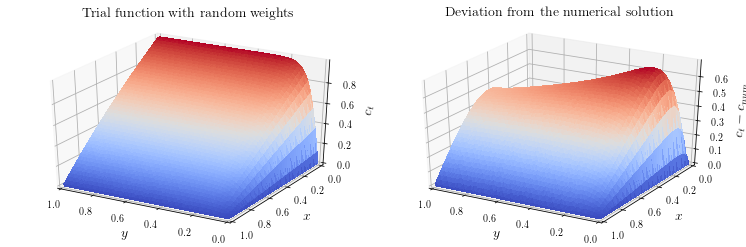

In [6]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = dataBasedModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "trial_function_random.pdf",
                     ["Trial function with random weights", "Deviation from the numerical solution"])

## Data driven learning using a trial function

In [7]:
training_points = np.column_stack((intField50.x, intField50.y))
dataBasedModel.set_control_points(training_points)
start = time.time()
dataBasedModel.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=False, tolerance=1.0E-5)
print("Time for 100 iterations: {:5.2f} min".format((time.time() - start) / 60.0))


The initial loss is 375.9459495336366

Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 1 iterations is E=373.07254500802543
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 2 iterations is E=370.22409110355176
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 3 iterations is E=367.4010908042502
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 4 iterations is E=364.60400355831655
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 5 iterations is E=361.8332000140046
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 6 iterations is E=359.0889531822155
Wrote weights to file ./trialFunctionDataBasedLearning/baselineMLP/best_weights
The loss after 7 iterations is E=356.3714325670884
Wrote weights to file ./trialFunctionDat

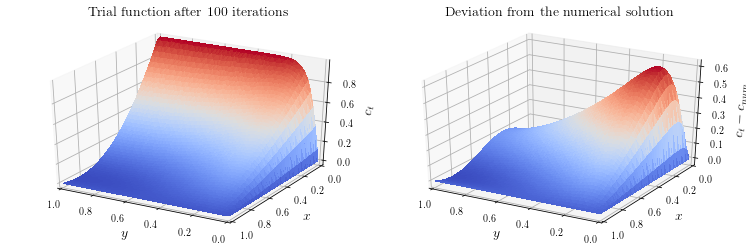

In [8]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = dataBasedModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "trialFunctionDataBasedLearning_100.pdf",
                     [r"Trial function after $100$ iterations", "Deviation from the numerical solution"])

## Residual based learning using a trial function

In [3]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
residualBasedModel = TrialFunctionResidualBasedLearning(name="trialFunctionResidualBasedLearning", mlp=baselineMLP, beta=25.0, d_v=0.025)
residualBasedModel.place_control_points(method=['uniform', 'uniform'], domain=[(0.0, 1.0), (0.0, 1.0)], step_size=[0.021, 0.021], growths=[1.3, 1.3])
start = time.time()
residualBasedModel.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=False, tolerance=1.0E-5)
print("Time for 100 iterations: {:5.2f} min".format((time.time() - start) / 60.0))


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20

Placing control points for 2 input variables.
------------------------------------------------
Control points per input parameter: [49, 49]
The total number of control points is 2401

The initial loss is 11493.059978343317

Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 1 iterations is E=11478.309182717705
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 2 iterations is E=11463.644854983102
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 3 iterations is E=11449.069868227964
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 4 iterations is E=11434.586543965825
Wrote weights to file ./trialFunctionResidualBasedLearn

The loss after 58 iterations is E=10674.30881301879
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 59 iterations is E=10657.835220868878
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 60 iterations is E=10641.241055165458
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 61 iterations is E=10624.529358173242
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 62 iterations is E=10607.703438226676
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 63 iterations is E=10590.766857122264
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 64 iterations is E=10573.723418384878
Wrote weights to file ./trialFunctionResidualBasedLearning/baselineMLP/best_weights
The loss after 65 iterations is E=10556.57

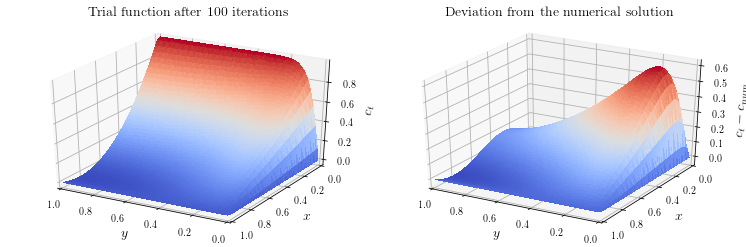

In [4]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = residualBasedModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "trialFunctionResidualBasedLearning_100.pdf",
                     [r"Trial function after $100$ iterations", "Deviation from the numerical solution"])

## Data based learning with the pure network
### no penalty term for boundary points

In [5]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
pureNetworkModel = PureNetworkLearning(name="pureNetworkLearningNoP", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025, penalty=1.0)
training_points = np.column_stack((field50.x, field50.y))
pureNetworkModel.set_control_points(training_points)
start = time.time()
pureNetworkModel.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=False, tolerance=1.0E-5)
print("Time for 100 iterations: {:5.2f} min".format((time.time() - start) / 60.0))


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20

The initial loss is 22081.244781940826

Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 1 iterations is E=20852.894843201993
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 2 iterations is E=19658.802820433983
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 3 iterations is E=18499.813774432292
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 4 iterations is E=17376.722346582577
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 5 iterations is E=16290.267047105555
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 6 iterations is E=15241.12452608688
Wrote weights to file ./pureNetworkLearn

Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 89 iterations is E=500.45327655779687
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 90 iterations is E=499.30200507944494
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 91 iterations is E=498.1494052569971
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 92 iterations is E=496.9870940508173
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 93 iterations is E=495.8088034978783
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 94 iterations is E=494.61019324858535
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 95 iterations is E=493.38863551815507
Wrote weights to file ./pureNetworkLearningNoP/baselineMLP/best_weights
The loss after 96 iterations is E=492.1429832969289
Wrot

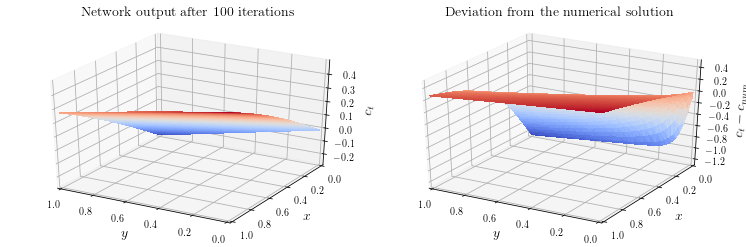

In [6]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = pureNetworkModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "pureNetwork_100.pdf",
                     [r"Network output after $100$ iterations", "Deviation from the numerical solution"])

### penalty factor 2 for points on the boundaries

In [7]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
pureNetworkModelPenalty = PureNetworkLearning(name="pureNetworkLearning", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025, penalty=2.0)
training_points = np.column_stack((field50.x, field50.y))
pureNetworkModelPenalty.set_control_points(training_points)
start = time.time()
pureNetworkModelPenalty.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=False, tolerance=1.0E-5)
print("Time for 100 iterations: {:5.2f} min".format((time.time() - start) / 60.0))


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20

The initial loss is 27566.74086563324

Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 1 iterations is E=26054.08858856372
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 2 iterations is E=24583.26152251178
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 3 iterations is E=23155.28905810074
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 4 iterations is E=21771.139639706245
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 5 iterations is E=20431.713897546815
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 6 iterations is E=19137.837763666295
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_

The loss after 88 iterations is E=743.4624091711554
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 89 iterations is E=741.4180440006422
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 90 iterations is E=739.3950446118212
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 91 iterations is E=737.3792820375695
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 92 iterations is E=735.3593209715484
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 93 iterations is E=733.326285555149
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 94 iterations is E=731.273671278628
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 95 iterations is E=729.1971169539808
Wrote weights to file ./pureNetworkLearning/baselineMLP/best_weights
The loss after 96 iterations is E=

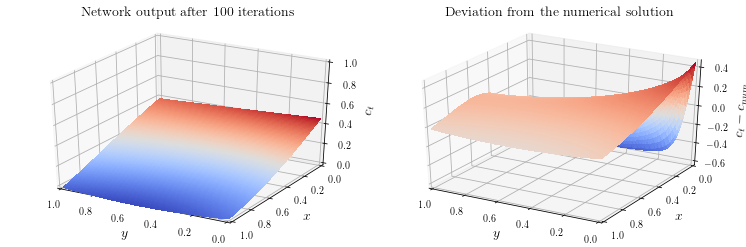

In [42]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = pureNetworkModelPenalty.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "pureNetworkPenalty_100.pdf",
                     [r"Network output after $100$ iterations", "Deviation from the numerical solution"])

## Data based learning using a custom function

In [8]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearning", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20


### Visualize custom function

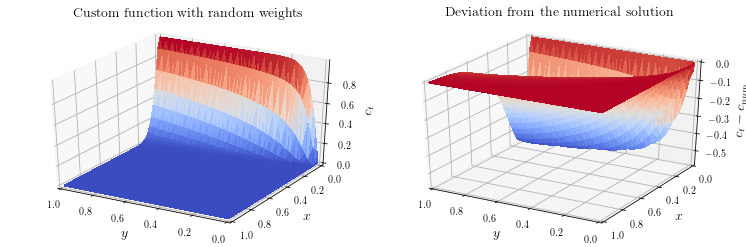

In [9]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = customModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "customFunctionLearning_randomWeights.pdf",
                     [r"Custom function with random weights", "Deviation from the numerical solution"])

In [10]:
training_points = np.column_stack((field50.x, field50.y))
customModel.set_control_points(training_points)
start = time.time()
customModel.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=False, tolerance=1.0E-5)
print("Time for 100 iterations: {:5.2f} min".format((time.time() - start) / 60.0))


The initial loss is 106.69989434100859

Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 1 iterations is E=104.14263177946617
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 2 iterations is E=101.4669958326886
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 3 iterations is E=98.66338353437207
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 4 iterations is E=95.7212175517689
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 5 iterations is E=92.62885012542628
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 6 iterations is E=89.37346485455804
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 7 iterations is E=85.94098163872204
Wrote weights to file ./customFunctionLearning/baselineMLP/best_weights
The loss after 8 iteration

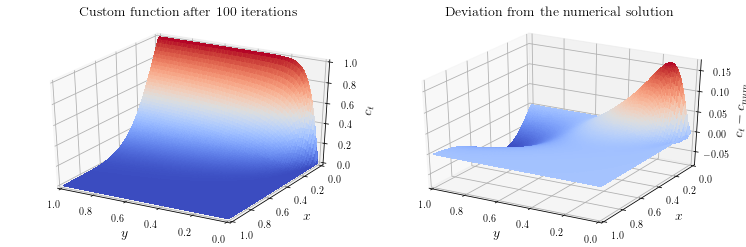

In [51]:
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = customModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "customFunctionLearning_100.pdf",
                     [r"Custom function after $100$ iterations", "Deviation from the numerical solution"])

In [8]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearning", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearning/baselineMLP/best_weights.npy")
evaluation_points = np.column_stack((field50.x, field50.y))
l2_norm = customModel.l2_norm(evaluation_points, field50.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field50.A)
print("-------------------")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearning/baselineMLP/best_weights.npy
-------------------
L2 norm:  0.0004907119808029378
Lmax norm:  0.11179031469916989


## Adaptive learning
### Custom function after 100 iterations

In [4]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
training_points = np.column_stack((field50.x, field50.y))
customModel.set_control_points(training_points)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20


In [5]:
start = time.time()
customModel.solve(max_iter=100, learning_rate=0.01, verbose=1, adaptive=True, tolerance=0.01, every=1000)
print("Elapsed time: {:5.2f} min".format((time.time() - start) / 60.0))

Selecting subset for training: 2 out of 2700 selected.

The initial loss is 0.013029879834008608

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 1 iterations is E=0.013029879258117704
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 2 iterations is E=0.013029878195884964
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 3 iterations is E=0.013029876145898855
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 4 iterations is E=0.013029872059175836
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 5 iterations is E=0.013029863788949818
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 6 iterations is E=0.013029847063490656
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 7 i

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 58 iterations is E=0.01130656795950899
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 59 iterations is E=0.01051298618378276
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 64 iterations is E=0.010216368412766673
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 65 iterations is E=0.009992729582317277
Using every 182th point for                         training.
Selecting subset for training: 14 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss after 66 iterations is E=0.004867519492894525
Using every 163th point for                         training.
Selecting subset for training: 16 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP/best_weights
The loss af


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearningAdaptive/baselineMLP/best_weights.npy
-------------------
L2 norm:  0.0004156393510664309
Lmax norm:  0.10435761221395723


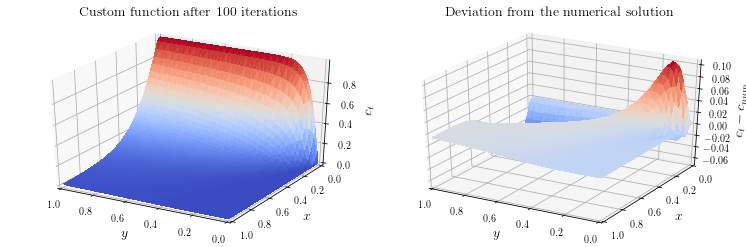

In [5]:
baselineMLP = SimpleMLP(name='baselineMLP', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLP/best_weights.npy")
evaluation_points = np.column_stack((field50.x, field50.y))
prediction = customModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "customFunctionBaseline100.pdf",
                     [r"Custom function after $100$ iterations", "Deviation from the numerical solution"])
l2_norm = customModel.l2_norm(evaluation_points, field50.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field50.A)
print("-------------------")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)

### Custom function after 1000 iterations

In [16]:
baselineMLP = SimpleMLP(name='baselineMLP1000', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
training_points = np.column_stack((field50.x, field50.y))
customModel.set_control_points(training_points)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20


In [17]:
start = time.time()
customModel.solve(max_iter=1000, learning_rate=0.01, verbose=1, adaptive=True, tolerance=0.01, every=1000)
print("Elapsed time: {:5.2f} min".format((time.time() - start) / 60.0))

Selecting subset for training: 2 out of 2700 selected.

The initial loss is 0.004174917303204653

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 1 iterations is E=0.0041749173032041365
Using every 900th point for                         training.
Selecting subset for training: 3 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 2 iterations is E=0.13128558100018836
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 3 iterations is E=0.13111885591431688
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 4 iterations is E=0.1308866853520578
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 5 iterations is E=0.13057082515360766
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 55 iterations is E=0.009659764738411491
Using every 182th point for                         training.
Selecting subset for training: 14 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 56 iterations is E=0.006704000389638443
Using every 163th point for                         training.
Selecting subset for training: 16 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 57 iterations is E=0.018300690137653085
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 58 iterations is E=0.017896495842578106
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 59 iterations is E=0.014233421365006077
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP100

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 147 iterations is E=0.011110437280053153
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 151 iterations is E=0.011044495954371698
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 152 iterations is E=0.010952829052889537
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 156 iterations is E=0.010679552236277838
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 160 iterations is E=0.010613467668347564
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 161 iterations is E=0.010484386149727392
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 165 iterations is E=0.01030688064567326
Wrote weights to file

The loss after 232 iterations is E=0.010559849670653572
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 233 iterations is E=0.010471193836756662
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 234 iterations is E=0.010376054691257755
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 235 iterations is E=0.010273970495134517
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 236 iterations is E=0.01019125601734064
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 237 iterations is E=0.01010026837327476
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 238 iterations is E=0.010008699706421712
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 239 ite

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 311 iterations is E=0.01189233889934809
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 312 iterations is E=0.011850480905659395
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 313 iterations is E=0.011820053783841883
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 314 iterations is E=0.011776850691813591
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 315 iterations is E=0.011751025572985928
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 316 iterations is E=0.011712530902155542
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 317 iterations is E=0.011684889438653177
Wrote weights to file

The loss after 371 iterations is E=0.010666172470869947
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 372 iterations is E=0.01065563359282325
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 373 iterations is E=0.010645230247994398
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 374 iterations is E=0.010635029880674862
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 375 iterations is E=0.010624959577820715
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 376 iterations is E=0.01061507314693553
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 377 iterations is E=0.010605321330277305
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 378 ite

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 431 iterations is E=0.010214567794650199
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 432 iterations is E=0.010208574970524383
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 433 iterations is E=0.010202595145005704
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 434 iterations is E=0.01019662729992452
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 435 iterations is E=0.010190670184462028
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 436 iterations is E=0.010184722855428359
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 437 iterations is E=0.010178784166857227
Wrote weights to file

The loss after 490 iterations is E=0.016429442076709072
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 491 iterations is E=0.01639831838373568
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 492 iterations is E=0.016374992496537153
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 493 iterations is E=0.016346586602173124
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 494 iterations is E=0.0163155365898413
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 495 iterations is E=0.016290309819891567
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 496 iterations is E=0.01626206191247018
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 497 itera

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 550 iterations is E=0.014572002249785661
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 551 iterations is E=0.014538794915626851
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 552 iterations is E=0.014505544448753153
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 553 iterations is E=0.01447223525833628
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 554 iterations is E=0.014438885122985188
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 555 iterations is E=0.01440550299648434
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 556 iterations is E=0.01437207485684804
Wrote weights to file .

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 609 iterations is E=0.012575792955732905
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 610 iterations is E=0.012542063583280855
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 611 iterations is E=0.012508362369365705
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 612 iterations is E=0.012474690482701107
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 613 iterations is E=0.012441049148083824
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 614 iterations is E=0.012407439457698193
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 615 iterations is E=0.012373862695905104
Wrote weights to fil

The loss after 668 iterations is E=0.01067266991080956
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 669 iterations is E=0.010642639271152362
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 670 iterations is E=0.010612706452727565
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 671 iterations is E=0.010582872548941106
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 672 iterations is E=0.010553138637072005
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 673 iterations is E=0.010523505794217259
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 674 iterations is E=0.010493975079641003
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 675 it

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 774 iterations is E=0.010556939043287113
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 775 iterations is E=0.010547570528786887
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 776 iterations is E=0.0105385219766031
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 777 iterations is E=0.010535782607585698
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 778 iterations is E=0.01052911533378691
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 779 iterations is E=0.0105197984187246
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 780 iterations is E=0.010515302486004255
Wrote weights to file ./c

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 833 iterations is E=0.0102030209130999
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 834 iterations is E=0.010197418584783794
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 835 iterations is E=0.010191816711300603
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 836 iterations is E=0.010186234692278312
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 837 iterations is E=0.0101806652495528
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 838 iterations is E=0.010175093972322437
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 839 iterations is E=0.010169529308623592
Wrote weights to file ./

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 930 iterations is E=0.015667339047515157
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 932 iterations is E=0.015632347292667728
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 934 iterations is E=0.015599051886606437
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 936 iterations is E=0.015571955757130732
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 938 iterations is E=0.015546320695133384
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 940 iterations is E=0.015524487138617612
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights
The loss after 942 iterations is E=0.015503763065462167
Wrote weights to fil

In [22]:
baselineMLP = SimpleMLP(name='baselineMLP1000', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLP1000/best_weights.npy")
evaluation_points = np.column_stack((field50.x, field50.y))
l2_norm = customModel.l2_norm(evaluation_points, field50.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field50.A)
print("-------------------")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights.npy
-------------------
L2 norm:  0.00013313799350845017
Lmax norm:  0.05359531848654081


### Non-adaptive after 1000 iterations (for comparison)

In [19]:
baselineMLP = SimpleMLP(name='baselineMLP1000', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearning", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
training_points = np.column_stack((field50.x, field50.y))
customModel.set_control_points(training_points)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20


In [20]:
start = time.time()
customModel.solve(max_iter=1000, learning_rate=0.01, verbose=1, adaptive=False, tolerance=0.01)
print("Elapsed time: {:5.2f} min".format((time.time() - start) / 60.0))


The initial loss is 106.69989434100859

Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 1 iterations is E=104.14263177946617
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 2 iterations is E=101.4669958326886
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 3 iterations is E=98.66338353437207
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 4 iterations is E=95.7212175517689
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 5 iterations is E=92.62885012542628
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 6 iterations is E=89.37346485455804
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 7 iterations is E=85.94098163872204
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_we

The loss after 112 iterations is E=1.6952817025735079
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 113 iterations is E=1.690113948938757
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 114 iterations is E=1.6848651512869104
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 115 iterations is E=1.6797553702128551
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 116 iterations is E=1.6749188501797583
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 117 iterations is E=1.6703686031922023
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 118 iterations is E=1.6660142821278336
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 119 iterations is E=1.6617158232807976
Wrote weights to file ./customFunctio

The loss after 176 iterations is E=1.4205191021143728
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 177 iterations is E=1.416597348286397
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 178 iterations is E=1.4126847827418234
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 179 iterations is E=1.4087817429555127
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 180 iterations is E=1.4048884789365375
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 181 iterations is E=1.4010050437520918
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 182 iterations is E=1.3971312928339612
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 183 iterations is E=1.393266973167305
Wrote weights to file ./customFunction

The loss after 240 iterations is E=1.1879278258786106
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 241 iterations is E=1.1845815529952657
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 242 iterations is E=1.1812439682834621
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 243 iterations is E=1.1779150654445734
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 244 iterations is E=1.174594838398596
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 245 iterations is E=1.1712832814334952
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 246 iterations is E=1.1679803891487317
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 247 iterations is E=1.1646861562567672
Wrote weights to file ./customFunctio

The loss after 304 iterations is E=0.9910262522980386
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 305 iterations is E=0.9882230061457313
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 306 iterations is E=0.9854279842209329
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 307 iterations is E=0.9826411763911672
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 308 iterations is E=0.9798625724204992
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 309 iterations is E=0.9770921619701292
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 310 iterations is E=0.9743299345985754
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 311 iterations is E=0.9715758797615303
Wrote weights to file ./customFuncti

The loss after 368 iterations is E=0.8277137706818319
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 369 iterations is E=0.8254124311929723
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 370 iterations is E=0.8231184810238779
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 371 iterations is E=0.8208319046858332
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 372 iterations is E=0.8185526866360501
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 373 iterations is E=0.8162808112786649
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 374 iterations is E=0.8140162629657407
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 375 iterations is E=0.8117590259982489
Wrote weights to file ./customFuncti

The loss after 432 iterations is E=0.6946527079303063
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 433 iterations is E=0.6927914243804242
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 434 iterations is E=0.6909364697825453
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 435 iterations is E=0.6890878270665056
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 436 iterations is E=0.6872454791639544
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 437 iterations is E=0.6854094090090413
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 438 iterations is E=0.6835795995390656
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 439 iterations is E=0.6817560336951385
Wrote weights to file ./customFuncti

The loss after 496 iterations is E=0.5875842734192984
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 497 iterations is E=0.5860940791012632
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 498 iterations is E=0.584609148514354
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 499 iterations is E=0.5831294657739019
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 500 iterations is E=0.5816550150264819
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 501 iterations is E=0.5801857804501912
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 502 iterations is E=0.5787217462548865
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 503 iterations is E=0.5772628966824498
Wrote weights to file ./customFunctio

The loss after 560 iterations is E=0.5021831657481918
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 561 iterations is E=0.5009992564847553
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 562 iterations is E=0.49981966509832354
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 563 iterations is E=0.49864437803258477
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 564 iterations is E=0.4974733817700735
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 565 iterations is E=0.49630666283219493
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 566 iterations is E=0.49514420777920226
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 567 iterations is E=0.49398600321021296
Wrote weights to file ./customF

The loss after 623 iterations is E=0.43551434970310426
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 624 iterations is E=0.4345775181586131
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 625 iterations is E=0.4336442249924992
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 626 iterations is E=0.4327144590103014
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 627 iterations is E=0.43178820905245824
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 628 iterations is E=0.4308654639942029
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 629 iterations is E=0.4299462127454451
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 630 iterations is E=0.4290304442506769
Wrote weights to file ./customFunc

The loss after 686 iterations is E=0.3829798508346496
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 687 iterations is E=0.38224539096064486
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 688 iterations is E=0.38151382769616093
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 689 iterations is E=0.38078515181153283
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 690 iterations is E=0.3800593541042634
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 691 iterations is E=0.3793364253989241
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 692 iterations is E=0.3786163565470125
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 693 iterations is E=0.37789913842683237
Wrote weights to file ./customFu

The loss after 749 iterations is E=0.3420147709819797
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 750 iterations is E=0.3414457791622907
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 751 iterations is E=0.3408791508071815
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 752 iterations is E=0.3403148781698983
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 753 iterations is E=0.33975295352378965
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 754 iterations is E=0.3391933691622185
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 755 iterations is E=0.33863611739846705
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 756 iterations is E=0.3380811905656403
Wrote weights to file ./customFunc

The loss after 812 iterations is E=0.31048785802733275
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 813 iterations is E=0.31005338182441355
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 814 iterations is E=0.3096208169479248
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 815 iterations is E=0.3091901567595295
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 816 iterations is E=0.30876139463633984
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 817 iterations is E=0.3083345239708646
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 818 iterations is E=0.3079095381709568
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 819 iterations is E=0.3074864306597566
Wrote weights to file ./customFun

The loss after 875 iterations is E=0.2865939325575308
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 876 iterations is E=0.2862674912685511
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 877 iterations is E=0.2859425715009399
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 878 iterations is E=0.28561916750855
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 879 iterations is E=0.2852972735584053
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 880 iterations is E=0.2849768839306825
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 881 iterations is E=0.2846579929186865
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 882 iterations is E=0.2843405948288365
Wrote weights to file ./customFunction

The loss after 938 iterations is E=0.2687791959781516
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 939 iterations is E=0.26853790094888
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 940 iterations is E=0.26829779049826463
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 941 iterations is E=0.2680588596802354
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 942 iterations is E=0.2678211035610912
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 943 iterations is E=0.2675845172194944
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 944 iterations is E=0.2673490957464652
Wrote weights to file ./customFunctionLearning/baselineMLP1000/best_weights
The loss after 945 iterations is E=0.2671148342453735
Wrote weights to file ./customFunctio

In [23]:
baselineMLP = SimpleMLP(name='baselineMLP1000', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearning", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearning/baselineMLP1000/best_weights.npy")
evaluation_points = np.column_stack((field50.x, field50.y))
l2_norm = customModel.l2_norm(evaluation_points, field50.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field50.A)
print("-------------------")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearning/baselineMLP1000/best_weights.npy
-------------------
L2 norm:  0.00018734984662657056
Lmax norm:  0.08510684116093437


## Final baseline model evaluation
### Custom function learning

In [3]:
baselineMLP = SimpleMLP(name='baselineMLPFinal', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLP1000/best_weights.npy")
training_points = np.column_stack((field50.x, field50.y))
customModel.set_control_points(training_points)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearningAdaptive/baselineMLP1000/best_weights.npy


In [19]:
start = time.time()
customModel.solve(max_iter=2000, learning_rate=0.01, verbose=1, adaptive=True, tolerance=0.01, every=1000)
print("Elapsed time: {:5.2f} min".format((time.time() - start) / 60.0))

Selecting subset for training: 2 out of 2700 selected.

The initial loss is 0.00011192855542033302

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1 iterations is E=4.0502535880974184e-05
Using every 900th point for                         training.
Selecting subset for training: 3 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 2 iterations is E=0.00035376955638237114
Using every 810th point for                         training.
Selecting subset for training: 3 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 3 iterations is E=0.0001875523753889355
Using every 729th point for                         training.
Selecting subset for training: 3 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 4 iterations is E=0.0013327

Selecting subset for training: 112 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 35 iterations is E=0.004506808445765395
Using every 21th point for                         training.
Selecting subset for training: 128 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 36 iterations is E=0.012052790630535245
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 37 iterations is E=0.01002920534529858
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 39 iterations is E=0.009879327247823063
Using every 18th point for                         training.
Selecting subset for training: 150 out of 2700 selected.
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 40 iterations is E=0.011125917626903898
Wrote we

The loss after 128 iterations is E=0.014786327951429576
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 129 iterations is E=0.014758283781214528
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 130 iterations is E=0.014736042963030703
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 131 iterations is E=0.01472078831269797
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 132 iterations is E=0.014712340199590824
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 133 iterations is E=0.014709222229762288
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 137 iterations is E=0.014708463855551425
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after

The loss after 230 iterations is E=0.014100033231116672
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 231 iterations is E=0.014093473819956145
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 232 iterations is E=0.014086556361412834
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 233 iterations is E=0.014079717671117523
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 234 iterations is E=0.014073229245240765
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 235 iterations is E=0.014067097213589425
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 236 iterations is E=0.01406113151337171
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after

The loss after 331 iterations is E=0.013471391213222973
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 332 iterations is E=0.013463330501304325
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 333 iterations is E=0.013457321392123047
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 334 iterations is E=0.013452585047476356
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 335 iterations is E=0.013447602727665159
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 336 iterations is E=0.013441327203464706
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 337 iterations is E=0.013433895300859363
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss afte

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 430 iterations is E=0.012841928658126032
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 431 iterations is E=0.01282326591298625
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 432 iterations is E=0.01281761889799889
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 435 iterations is E=0.012812786920364277
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 436 iterations is E=0.012798051373764269
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 437 iterations is E=0.012784697505226863
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 438 iterations is E=0.012777821624228311
Wrote weights t

The loss after 490 iterations is E=0.012432147234121347
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 491 iterations is E=0.01242533387697948
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 492 iterations is E=0.012418522717648707
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 493 iterations is E=0.012411717111417328
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 494 iterations is E=0.012404925371084091
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 495 iterations is E=0.01239815666655058
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 496 iterations is E=0.012391431044555652
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 594 iterations is E=0.01177232275135956
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 595 iterations is E=0.011765742585157564
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 596 iterations is E=0.01175937605476384
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 597 iterations is E=0.011753216943290625
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 598 iterations is E=0.011747137138652584
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 599 iterations is E=0.011740992533568095
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 600 iterations is E=0.011734702775892414
Wrote weights t

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 653 iterations is E=0.01140105690867625
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 654 iterations is E=0.011395690214064341
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 655 iterations is E=0.01139089785714531
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 656 iterations is E=0.01138713730243556
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 657 iterations is E=0.011384992546165337
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 672 iterations is E=0.011341785137929819
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 678 iterations is E=0.011249557207702815
Wrote weights to

The loss after 758 iterations is E=0.010816350689641456
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 759 iterations is E=0.010810938015277972
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 760 iterations is E=0.01080556444579734
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 761 iterations is E=0.010800264992261544
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 762 iterations is E=0.010795032333963438
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 763 iterations is E=0.01078983082875837
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 764 iterations is E=0.010784620985209397
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 

The loss after 817 iterations is E=0.01051197433296578
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 818 iterations is E=0.010506987108149297
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 819 iterations is E=0.010502015566120793
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 820 iterations is E=0.010497065728026313
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 821 iterations is E=0.010492149416868072
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 822 iterations is E=0.010487284849907418
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 823 iterations is E=0.010482507420054925
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after

Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1063 iterations is E=0.013261644549884275
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1064 iterations is E=0.013258757863000788
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1065 iterations is E=0.013257218521859754
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1066 iterations is E=0.013255054400562091
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1067 iterations is E=0.013252870860069663
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1068 iterations is E=0.013251310203241348
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1069 iterations is E=0.013248867941910233
Wrote 

The loss after 1121 iterations is E=0.013171304160084692
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1122 iterations is E=0.01317015437841712
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1123 iterations is E=0.013169011195753767
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1124 iterations is E=0.013167881350218666
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1125 iterations is E=0.013166759373389141
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1126 iterations is E=0.013165648317260286
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1127 iterations is E=0.013164547245435346
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

The loss after 1179 iterations is E=0.013118406051811648
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1180 iterations is E=0.013117692936217574
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1181 iterations is E=0.013116985100032758
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1182 iterations is E=0.013116282483332839
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1183 iterations is E=0.013115585018489691
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1184 iterations is E=0.013114892654934089
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1185 iterations is E=0.013114205321892848
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The lo

The loss after 1237 iterations is E=0.01308412330262947
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1238 iterations is E=0.013083632438024533
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1239 iterations is E=0.013083144196303215
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1240 iterations is E=0.013082658545206573
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1241 iterations is E=0.013082175452784285
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1242 iterations is E=0.013081694887509633
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1243 iterations is E=0.013081216818159111
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

The loss after 1352 iterations is E=0.013038942740577217
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1353 iterations is E=0.013038611074665748
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1354 iterations is E=0.013038279994381508
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1355 iterations is E=0.013037949491751818
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1356 iterations is E=0.013037619558905738
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1357 iterations is E=0.01303729018807312
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1358 iterations is E=0.0130369613715831
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss 

The loss after 1410 iterations is E=0.013020466312912616
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1411 iterations is E=0.013020158118732177
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1412 iterations is E=0.013019850183775626
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1413 iterations is E=0.01301954250433061
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1414 iterations is E=0.01301923507673453
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1415 iterations is E=0.01301892789737376
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1416 iterations is E=0.013018620962683369
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss 

The loss after 1469 iterations is E=0.013002625483635575
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1470 iterations is E=0.01300232759471596
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1471 iterations is E=0.013002029813536473
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1472 iterations is E=0.013001732138444976
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1473 iterations is E=0.013001434567812048
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1474 iterations is E=0.013001137100030603
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1475 iterations is E=0.013000839733515984
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

The loss after 1527 iterations is E=0.012985483435764321
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1528 iterations is E=0.012985189652643248
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1529 iterations is E=0.01298489591100991
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1530 iterations is E=0.012984602210124456
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1531 iterations is E=0.012984308549257327
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1532 iterations is E=0.012984014927688699
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1533 iterations is E=0.012983721344708418
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

The loss after 1585 iterations is E=0.012968493429451396
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1586 iterations is E=0.01296820108559154
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1587 iterations is E=0.012967908753128239
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1588 iterations is E=0.012967616431713683
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1589 iterations is E=0.012967324121004535
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1590 iterations is E=0.012967031820661348
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1591 iterations is E=0.012966739530348862
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

The loss after 1701 iterations is E=0.012934591186798594
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1702 iterations is E=0.012934298558433355
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1703 iterations is E=0.012934005917621637
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1704 iterations is E=0.012933713264235725
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1705 iterations is E=0.012933420598148835
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1706 iterations is E=0.012933127919234438
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1707 iterations is E=0.012932835227366874
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The lo

The loss after 1760 iterations is E=0.012917300905807024
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1761 iterations is E=0.012917007340938962
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1762 iterations is E=0.012916713756886529
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1763 iterations is E=0.012916420153545665
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1764 iterations is E=0.012916126530812533
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1765 iterations is E=0.01291583288858355
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1766 iterations is E=0.01291553922675554
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss

The loss after 1818 iterations is E=0.01290023931173818
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1819 iterations is E=0.012899944468567856
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1820 iterations is E=0.012899649600503712
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1821 iterations is E=0.012899354707451956
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1822 iterations is E=0.012899059789319123
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1823 iterations is E=0.012898764846011827
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1824 iterations is E=0.01289846987743676
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss

The loss after 1876 iterations is E=0.012883094424146584
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1877 iterations is E=0.012882797986341066
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1878 iterations is E=0.012882501518422906
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1879 iterations is E=0.01288220502030574
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1880 iterations is E=0.012881908491903493
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1881 iterations is E=0.01288161193313007
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1882 iterations is E=0.012881315343899497
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss

The loss after 1934 iterations is E=0.012865848646235481
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1935 iterations is E=0.012865550323177963
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1936 iterations is E=0.01286525196521494
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1937 iterations is E=0.012864953572267702
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1938 iterations is E=0.012864655144257695
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1939 iterations is E=0.012864356681106493
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The loss after 1940 iterations is E=0.012864058182735831
Wrote weights to file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights
The los

Loaded weights from file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy


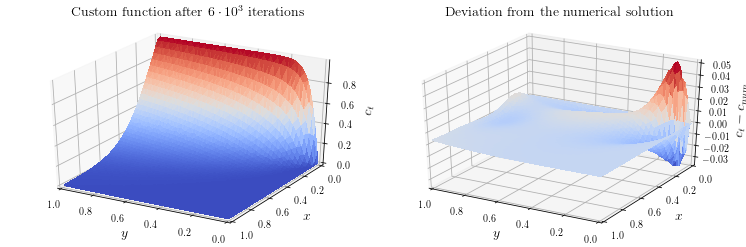

In [4]:
evaluation_points = np.column_stack((field50.x, field50.y))
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy")
prediction = customModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "customFunctionBaselineFinal.pdf",
                     [r"Custom function after $6\cdot 10^3$ iterations", "Deviation from the numerical solution"])

In [21]:
baselineMLP = SimpleMLP(name='baselineMLPFinal', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy")
evaluation_points = np.column_stack((field50.x, field50.y))
l2_norm = customModel.l2_norm(evaluation_points, field50.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field50.A)
print("-------------------")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy
-------------------
L2 norm:  0.00010439125648652941
Lmax norm:  0.050723566039886314


### Pure network learning

In [33]:
baselineMLP = SimpleMLP(name='baselineMLPFinal', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
pureNetworkModel = PureNetworkLearning(name="pureNetworkLearningNoP", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025, penalty=2.0)
training_points = np.column_stack((field50.x, field50.y))
pureNetworkModel.set_control_points(training_points)
start = time.time()
pureNetworkModel.solve(max_iter=30000, learning_rate=0.01, verbose=100, adaptive=True, tolerance=0.01, every=1000)
print("Elapsed time: {:5.2f} min".format((time.time() - start) / 60.0))


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Selecting subset for training: 2 out of 2700 selected.

The initial loss is 21.519028024986326

Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 100 iterations is E=0.3201399397845033
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 200 iterations is E=0.3031473168140498
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 300 iterations is E=0.28363602964543777
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 400 iterations is E=0.2634707813074062
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 500 iterations is E=0.24355516399053895
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_we

Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 4600 iterations is E=0.014177799740330985
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 4700 iterations is E=0.013118440525076614
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 4800 iterations is E=0.012385859707219919
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 4900 iterations is E=0.011821328584896592
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 5000 iterations is E=0.011346025958509481
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 5100 iterations is E=0.01091504151657842
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 5200 iterations is E=0.010506173085707317
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal

Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13000 iterations is E=0.020836905590882502
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13100 iterations is E=0.01975033526735414
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13200 iterations is E=0.018628248550572494
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13300 iterations is E=0.017192665160371053
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13400 iterations is E=0.015314389012410553
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13500 iterations is E=0.01293658925761635
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 13600 iterations is E=0.010531742060469109
Wrote weights to file ./pureNetworkLearningNoP/baselineML

Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 18500 iterations is E=0.008153423725063847
Using every 43th point for                         training.
Selecting subset for training: 62 out of 2700 selected.
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 18600 iterations is E=0.046522417999939024
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 18700 iterations is E=0.03474380304179608
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 18800 iterations is E=0.02807128642825682
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 18900 iterations is E=0.02301815012791361
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights
The loss after 19000 iterations is E=0.018999073366014634
Wrote weights to file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights

Loaded weights from file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights.npy


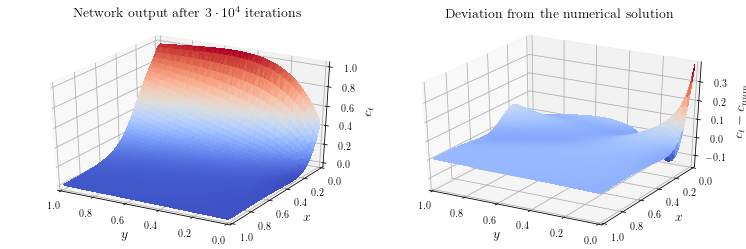

In [35]:
evaluation_points = np.column_stack((field50.x, field50.y))
pureNetworkModel.mlp.read_weights_from_disk("./pureNetworkLearningNoP/baselineMLPFinal/best_weights.npy")
prediction = pureNetworkModel.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, prediction, field50.A, "pureNetworkFinal.pdf",
                     [r"Network output after $3\cdot 10^4$ iterations", "Deviation from the numerical solution"])

### Keras/Tensorflow comparison

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

x_train = np.column_stack((field50.x, field50.y))

model = Sequential()
model.add(Dense(units=5, activation='sigmoid', name='dense1', input_dim=2))
model.add(Dense(units=1, name='dense2'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 5)                 15        
_________________________________________________________________
dense2 (Dense)               (None, 1)                 6         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [40]:
filepath = "keras/best_baseline_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=10, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit(x_train, field50.A, epochs=10000, callbacks=callbacks_list, batch_size=32)

Epoch 1/10000
2700/2700 [==============================] - 0s 84us/step - loss: 0.0910 - mean_absolute_error: 0.2498

Epoch 00001: loss improved from inf to 0.09104, saving model to keras/best_baseline_weights.hdf5
Epoch 2/10000
2700/2700 [==============================] - 0s 38us/step - loss: 0.0739 - mean_absolute_error: 0.2050

Epoch 00002: loss improved from 0.09104 to 0.07392, saving model to keras/best_baseline_weights.hdf5
Epoch 3/10000
2700/2700 [==============================] - 0s 42us/step - loss: 0.0659 - mean_absolute_error: 0.1901

Epoch 00003: loss improved from 0.07392 to 0.06589, saving model to keras/best_baseline_weights.hdf5
Epoch 4/10000
2700/2700 [==============================] - 0s 41us/step - loss: 0.0585 - mean_absolute_error: 0.1782

Epoch 00004: loss improved from 0.06589 to 0.05850, saving model to keras/best_baseline_weights.hdf5
Epoch 5/10000
2700/2700 [==============================] - 0s 44us/step - loss: 0.0520 - mean_absolute_error: 0.1652

Epoch 0000

2700/2700 [==============================] - 0s 44us/step - loss: 0.0082 - mean_absolute_error: 0.0627

Epoch 00075: loss improved from 0.00849 to 0.00816, saving model to keras/best_baseline_weights.hdf5
Epoch 76/10000
2700/2700 [==============================] - 0s 47us/step - loss: 0.0079 - mean_absolute_error: 0.0608

Epoch 00076: loss improved from 0.00816 to 0.00788, saving model to keras/best_baseline_weights.hdf5
Epoch 77/10000
2700/2700 [==============================] - 0s 51us/step - loss: 0.0076 - mean_absolute_error: 0.0591

Epoch 00077: loss improved from 0.00788 to 0.00759, saving model to keras/best_baseline_weights.hdf5
Epoch 78/10000
2700/2700 [==============================] - 0s 42us/step - loss: 0.0073 - mean_absolute_error: 0.0576

Epoch 00078: loss improved from 0.00759 to 0.00731, saving model to keras/best_baseline_weights.hdf5
Epoch 79/10000
2700/2700 [==============================] - 0s 48us/step - loss: 0.0071 - mean_absolute_error: 0.0560

Epoch 00079: los

2700/2700 [==============================] - 0s 48us/step - loss: 0.0030 - mean_absolute_error: 0.0305

Epoch 00150: loss improved from 0.00296 to 0.00296, saving model to keras/best_baseline_weights.hdf5
Epoch 151/10000
2700/2700 [==============================] - 0s 45us/step - loss: 0.0029 - mean_absolute_error: 0.0302

Epoch 00151: loss improved from 0.00296 to 0.00293, saving model to keras/best_baseline_weights.hdf5
Epoch 152/10000
2700/2700 [==============================] - 0s 47us/step - loss: 0.0029 - mean_absolute_error: 0.0307

Epoch 00152: loss did not improve
Epoch 153/10000
2700/2700 [==============================] - 0s 54us/step - loss: 0.0029 - mean_absolute_error: 0.0299

Epoch 00153: loss improved from 0.00293 to 0.00290, saving model to keras/best_baseline_weights.hdf5
Epoch 154/10000
2700/2700 [==============================] - 0s 44us/step - loss: 0.0029 - mean_absolute_error: 0.0304

Epoch 00154: loss did not improve
Epoch 155/10000
2700/2700 [==================

2700/2700 [==============================] - 0s 41us/step - loss: 0.0025 - mean_absolute_error: 0.0291

Epoch 00190: loss did not improve
Epoch 191/10000
2700/2700 [==============================] - 0s 38us/step - loss: 0.0025 - mean_absolute_error: 0.0291

Epoch 00191: loss did not improve
Epoch 192/10000
2700/2700 [==============================] - 0s 37us/step - loss: 0.0025 - mean_absolute_error: 0.0290

Epoch 00192: loss improved from 0.00253 to 0.00251, saving model to keras/best_baseline_weights.hdf5
Epoch 193/10000
2700/2700 [==============================] - 0s 36us/step - loss: 0.0025 - mean_absolute_error: 0.0288

Epoch 00193: loss improved from 0.00251 to 0.00250, saving model to keras/best_baseline_weights.hdf5
Epoch 194/10000
2700/2700 [==============================] - 0s 39us/step - loss: 0.0025 - mean_absolute_error: 0.0289

Epoch 00194: loss improved from 0.00250 to 0.00249, saving model to keras/best_baseline_weights.hdf5
Epoch 195/10000
2700/2700 [==================

2700/2700 [==============================] - 0s 55us/step - loss: 0.0019 - mean_absolute_error: 0.0248

Epoch 00269: loss improved from 0.00189 to 0.00189, saving model to keras/best_baseline_weights.hdf5
Epoch 270/10000
2700/2700 [==============================] - 0s 40us/step - loss: 0.0019 - mean_absolute_error: 0.0249

Epoch 00270: loss improved from 0.00189 to 0.00188, saving model to keras/best_baseline_weights.hdf5
Epoch 271/10000
2700/2700 [==============================] - 0s 39us/step - loss: 0.0019 - mean_absolute_error: 0.0249

Epoch 00271: loss improved from 0.00188 to 0.00188, saving model to keras/best_baseline_weights.hdf5
Epoch 272/10000
2700/2700 [==============================] - 0s 41us/step - loss: 0.0019 - mean_absolute_error: 0.0249

Epoch 00272: loss improved from 0.00188 to 0.00187, saving model to keras/best_baseline_weights.hdf5
Epoch 273/10000
2700/2700 [==============================] - 0s 53us/step - loss: 0.0019 - mean_absolute_error: 0.0244

Epoch 00273:

2700/2700 [==============================] - 0s 46us/step - loss: 0.0013 - mean_absolute_error: 0.0197

Epoch 00347: loss improved from 0.00126 to 0.00126, saving model to keras/best_baseline_weights.hdf5
Epoch 348/10000
2700/2700 [==============================] - 0s 41us/step - loss: 0.0012 - mean_absolute_error: 0.0196

Epoch 00348: loss improved from 0.00126 to 0.00124, saving model to keras/best_baseline_weights.hdf5
Epoch 349/10000
2700/2700 [==============================] - 0s 37us/step - loss: 0.0012 - mean_absolute_error: 0.0194

Epoch 00349: loss improved from 0.00124 to 0.00123, saving model to keras/best_baseline_weights.hdf5
Epoch 350/10000
2700/2700 [==============================] - 0s 44us/step - loss: 0.0012 - mean_absolute_error: 0.0192

Epoch 00350: loss improved from 0.00123 to 0.00122, saving model to keras/best_baseline_weights.hdf5
Epoch 351/10000
2700/2700 [==============================] - 0s 33us/step - loss: 0.0012 - mean_absolute_error: 0.0193

Epoch 00351:

2700/2700 [==============================] - 0s 24us/step - loss: 9.8497e-04 - mean_absolute_error: 0.0171

Epoch 00385: loss improved from 0.00099 to 0.00098, saving model to keras/best_baseline_weights.hdf5
Epoch 386/10000
2700/2700 [==============================] - 0s 25us/step - loss: 9.8842e-04 - mean_absolute_error: 0.0175

Epoch 00386: loss did not improve
Epoch 387/10000
2700/2700 [==============================] - 0s 24us/step - loss: 9.7960e-04 - mean_absolute_error: 0.0173

Epoch 00387: loss improved from 0.00098 to 0.00098, saving model to keras/best_baseline_weights.hdf5
Epoch 388/10000
2700/2700 [==============================] - 0s 22us/step - loss: 9.7366e-04 - mean_absolute_error: 0.0173

Epoch 00388: loss improved from 0.00098 to 0.00097, saving model to keras/best_baseline_weights.hdf5
Epoch 389/10000
2700/2700 [==============================] - 0s 22us/step - loss: 9.5893e-04 - mean_absolute_error: 0.0171

Epoch 00389: loss improved from 0.00097 to 0.00096, saving 

2700/2700 [==============================] - 0s 23us/step - loss: 7.8742e-04 - mean_absolute_error: 0.0153

Epoch 00425: loss improved from 0.00079 to 0.00079, saving model to keras/best_baseline_weights.hdf5
Epoch 426/10000
2700/2700 [==============================] - 0s 22us/step - loss: 7.8819e-04 - mean_absolute_error: 0.0157

Epoch 00426: loss did not improve
Epoch 427/10000
2700/2700 [==============================] - 0s 21us/step - loss: 7.8694e-04 - mean_absolute_error: 0.0157

Epoch 00427: loss improved from 0.00079 to 0.00079, saving model to keras/best_baseline_weights.hdf5
Epoch 428/10000
2700/2700 [==============================] - 0s 22us/step - loss: 7.7801e-04 - mean_absolute_error: 0.0154

Epoch 00428: loss improved from 0.00079 to 0.00078, saving model to keras/best_baseline_weights.hdf5
Epoch 429/10000
2700/2700 [==============================] - 0s 22us/step - loss: 7.8038e-04 - mean_absolute_error: 0.0155

Epoch 00429: loss did not improve
Epoch 430/10000
2700/2700


Epoch 00464: loss did not improve
Epoch 465/10000
2700/2700 [==============================] - 0s 22us/step - loss: 6.6678e-04 - mean_absolute_error: 0.0144

Epoch 00465: loss improved from 0.00067 to 0.00067, saving model to keras/best_baseline_weights.hdf5
Epoch 466/10000
2700/2700 [==============================] - 0s 23us/step - loss: 6.6985e-04 - mean_absolute_error: 0.0147

Epoch 00466: loss did not improve
Epoch 467/10000
2700/2700 [==============================] - 0s 22us/step - loss: 6.6436e-04 - mean_absolute_error: 0.0146

Epoch 00467: loss improved from 0.00067 to 0.00066, saving model to keras/best_baseline_weights.hdf5
Epoch 468/10000
2700/2700 [==============================] - 0s 21us/step - loss: 6.5984e-04 - mean_absolute_error: 0.0144

Epoch 00468: loss improved from 0.00066 to 0.00066, saving model to keras/best_baseline_weights.hdf5
Epoch 469/10000
2700/2700 [==============================] - 0s 21us/step - loss: 6.5867e-04 - mean_absolute_error: 0.0144

Epoch 00

2700/2700 [==============================] - 0s 23us/step - loss: 5.3528e-04 - mean_absolute_error: 0.0131

Epoch 00548: loss improved from 0.00054 to 0.00054, saving model to keras/best_baseline_weights.hdf5
Epoch 549/10000
2700/2700 [==============================] - 0s 25us/step - loss: 5.3617e-04 - mean_absolute_error: 0.0131

Epoch 00549: loss did not improve
Epoch 550/10000
2700/2700 [==============================] - 0s 23us/step - loss: 5.3917e-04 - mean_absolute_error: 0.0134

Epoch 00550: loss did not improve
Epoch 551/10000
2700/2700 [==============================] - 0s 24us/step - loss: 5.3590e-04 - mean_absolute_error: 0.0132

Epoch 00551: loss did not improve
Epoch 552/10000
2700/2700 [==============================] - 0s 24us/step - loss: 5.3312e-04 - mean_absolute_error: 0.0132

Epoch 00552: loss improved from 0.00054 to 0.00053, saving model to keras/best_baseline_weights.hdf5
Epoch 553/10000
2700/2700 [==============================] - 0s 22us/step - loss: 5.3031e-04

Epoch 593/10000
2700/2700 [==============================] - 0s 21us/step - loss: 5.0709e-04 - mean_absolute_error: 0.0129

Epoch 00593: loss did not improve
Epoch 594/10000
2700/2700 [==============================] - 0s 21us/step - loss: 5.1470e-04 - mean_absolute_error: 0.0133

Epoch 00594: loss did not improve
Epoch 595/10000
2700/2700 [==============================] - 0s 21us/step - loss: 5.0184e-04 - mean_absolute_error: 0.0129

Epoch 00595: loss improved from 0.00050 to 0.00050, saving model to keras/best_baseline_weights.hdf5
Epoch 596/10000
2700/2700 [==============================] - 0s 21us/step - loss: 5.0809e-04 - mean_absolute_error: 0.0132

Epoch 00596: loss did not improve
Epoch 597/10000
2700/2700 [==============================] - 0s 22us/step - loss: 5.1015e-04 - mean_absolute_error: 0.0132

Epoch 00597: loss did not improve
Epoch 598/10000
2700/2700 [==============================] - 0s 21us/step - loss: 5.1675e-04 - mean_absolute_error: 0.0136

Epoch 00598: loss d

2700/2700 [==============================] - 0s 22us/step - loss: 4.8562e-04 - mean_absolute_error: 0.0128

Epoch 00639: loss did not improve
Epoch 640/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.8604e-04 - mean_absolute_error: 0.0128

Epoch 00640: loss did not improve
Epoch 641/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.8520e-04 - mean_absolute_error: 0.0129

Epoch 00641: loss did not improve
Epoch 642/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.8393e-04 - mean_absolute_error: 0.0128

Epoch 00642: loss did not improve
Epoch 643/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.8321e-04 - mean_absolute_error: 0.0128

Epoch 00643: loss did not improve
Epoch 644/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.8571e-04 - mean_absolute_error: 0.0129

Epoch 00644: loss did not improve
Epoch 645/10000
2700/2700 [==============================] - 0s 21us


Epoch 00686: loss did not improve
Epoch 687/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.6838e-04 - mean_absolute_error: 0.0126

Epoch 00687: loss did not improve
Epoch 688/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.7032e-04 - mean_absolute_error: 0.0129

Epoch 00688: loss did not improve
Epoch 689/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.7495e-04 - mean_absolute_error: 0.0130

Epoch 00689: loss did not improve
Epoch 690/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.6741e-04 - mean_absolute_error: 0.0126

Epoch 00690: loss improved from 0.00047 to 0.00047, saving model to keras/best_baseline_weights.hdf5
Epoch 691/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.7383e-04 - mean_absolute_error: 0.0130

Epoch 00691: loss did not improve
Epoch 692/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.6698e-04 - mean_absolute

2700/2700 [==============================] - 0s 21us/step - loss: 4.5306e-04 - mean_absolute_error: 0.0128

Epoch 00783: loss did not improve
Epoch 784/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.6166e-04 - mean_absolute_error: 0.0133

Epoch 00784: loss did not improve
Epoch 785/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5879e-04 - mean_absolute_error: 0.0130

Epoch 00785: loss did not improve
Epoch 786/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5265e-04 - mean_absolute_error: 0.0129

Epoch 00786: loss did not improve
Epoch 787/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5164e-04 - mean_absolute_error: 0.0128

Epoch 00787: loss did not improve
Epoch 788/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5452e-04 - mean_absolute_error: 0.0128

Epoch 00788: loss did not improve
Epoch 789/10000
2700/2700 [==============================] - 0s 21us

2700/2700 [==============================] - 0s 21us/step - loss: 4.5008e-04 - mean_absolute_error: 0.0129

Epoch 00834: loss did not improve
Epoch 835/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.4378e-04 - mean_absolute_error: 0.0126

Epoch 00835: loss improved from 0.00045 to 0.00044, saving model to keras/best_baseline_weights.hdf5
Epoch 836/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.4847e-04 - mean_absolute_error: 0.0130

Epoch 00836: loss did not improve
Epoch 837/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5137e-04 - mean_absolute_error: 0.0131

Epoch 00837: loss did not improve
Epoch 838/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.4983e-04 - mean_absolute_error: 0.0130

Epoch 00838: loss did not improve
Epoch 839/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.5012e-04 - mean_absolute_error: 0.0129

Epoch 00839: loss did not improve
E

2700/2700 [==============================] - 0s 37us/step - loss: 4.4157e-04 - mean_absolute_error: 0.0130

Epoch 00935: loss did not improve
Epoch 936/10000
2700/2700 [==============================] - 0s 37us/step - loss: 4.4147e-04 - mean_absolute_error: 0.0129

Epoch 00936: loss did not improve
Epoch 937/10000
2700/2700 [==============================] - 0s 36us/step - loss: 4.3900e-04 - mean_absolute_error: 0.0129

Epoch 00937: loss improved from 0.00044 to 0.00044, saving model to keras/best_baseline_weights.hdf5
Epoch 938/10000
2700/2700 [==============================] - 0s 36us/step - loss: 4.4264e-04 - mean_absolute_error: 0.0130

Epoch 00938: loss did not improve
Epoch 939/10000
2700/2700 [==============================] - 0s 35us/step - loss: 4.4435e-04 - mean_absolute_error: 0.0132

Epoch 00939: loss did not improve
Epoch 940/10000
2700/2700 [==============================] - 0s 32us/step - loss: 4.4975e-04 - mean_absolute_error: 0.0133

Epoch 00940: loss did not improve
E

2700/2700 [==============================] - 0s 28us/step - loss: 4.3677e-04 - mean_absolute_error: 0.0129

Epoch 01034: loss did not improve
Epoch 1035/10000
2700/2700 [==============================] - 0s 28us/step - loss: 4.4327e-04 - mean_absolute_error: 0.0131

Epoch 01035: loss did not improve
Epoch 1036/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.4268e-04 - mean_absolute_error: 0.0131

Epoch 01036: loss did not improve
Epoch 1037/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.3688e-04 - mean_absolute_error: 0.0130

Epoch 01037: loss did not improve
Epoch 1038/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.4062e-04 - mean_absolute_error: 0.0131

Epoch 01038: loss did not improve
Epoch 1039/10000
2700/2700 [==============================] - 0s 34us/step - loss: 4.3819e-04 - mean_absolute_error: 0.0131

Epoch 01039: loss did not improve
Epoch 1040/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 4.3568e-04 - mean_absolute_error: 0.0130

Epoch 01135: loss did not improve
Epoch 1136/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.3297e-04 - mean_absolute_error: 0.0130

Epoch 01136: loss did not improve
Epoch 1137/10000
2700/2700 [==============================] - 0s 28us/step - loss: 4.3922e-04 - mean_absolute_error: 0.0132

Epoch 01137: loss did not improve
Epoch 1138/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.3576e-04 - mean_absolute_error: 0.0131

Epoch 01138: loss did not improve
Epoch 1139/10000
2700/2700 [==============================] - 0s 30us/step - loss: 4.3282e-04 - mean_absolute_error: 0.0129

Epoch 01139: loss did not improve
Epoch 1140/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.3687e-04 - mean_absolute_error: 0.0131

Epoch 01140: loss did not improve
Epoch 1141/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 4.3778e-04 - mean_absolute_error: 0.0131

Epoch 01186: loss did not improve
Epoch 1187/10000
2700/2700 [==============================] - 0s 31us/step - loss: 4.3698e-04 - mean_absolute_error: 0.0132

Epoch 01187: loss did not improve
Epoch 1188/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.3178e-04 - mean_absolute_error: 0.0130

Epoch 01188: loss did not improve
Epoch 1189/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.3248e-04 - mean_absolute_error: 0.0130

Epoch 01189: loss did not improve
Epoch 1190/10000
2700/2700 [==============================] - 0s 24us/step - loss: 4.3211e-04 - mean_absolute_error: 0.0129

Epoch 01190: loss did not improve
Epoch 1191/10000
2700/2700 [==============================] - 0s 24us/step - loss: 4.3297e-04 - mean_absolute_error: 0.0131

Epoch 01191: loss did not improve
Epoch 1192/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 22us/step - loss: 4.3415e-04 - mean_absolute_error: 0.0131

Epoch 01237: loss did not improve
Epoch 1238/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.3255e-04 - mean_absolute_error: 0.0130

Epoch 01238: loss did not improve
Epoch 1239/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.3642e-04 - mean_absolute_error: 0.0132

Epoch 01239: loss did not improve
Epoch 1240/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.3250e-04 - mean_absolute_error: 0.0130

Epoch 01240: loss did not improve
Epoch 1241/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.3290e-04 - mean_absolute_error: 0.0131

Epoch 01241: loss did not improve
Epoch 1242/10000
2700/2700 [==============================] - 0s 23us/step - loss: 4.3271e-04 - mean_absolute_error: 0.0131

Epoch 01242: loss did not improve
Epoch 1243/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 23us/step - loss: 4.3096e-04 - mean_absolute_error: 0.0131

Epoch 01338: loss did not improve
Epoch 1339/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.3008e-04 - mean_absolute_error: 0.0131

Epoch 01339: loss did not improve
Epoch 1340/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.3068e-04 - mean_absolute_error: 0.0131

Epoch 01340: loss did not improve
Epoch 1341/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.3421e-04 - mean_absolute_error: 0.0132

Epoch 01341: loss did not improve
Epoch 1342/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.3518e-04 - mean_absolute_error: 0.0132

Epoch 01342: loss did not improve
Epoch 1343/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.3380e-04 - mean_absolute_error: 0.0132

Epoch 01343: loss did not improve
Epoch 1344/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 22us/step - loss: 4.3648e-04 - mean_absolute_error: 0.0133

Epoch 01389: loss did not improve
Epoch 1390/10000
2700/2700 [==============================] - 0s 24us/step - loss: 4.2891e-04 - mean_absolute_error: 0.0130

Epoch 01390: loss did not improve
Epoch 1391/10000
2700/2700 [==============================] - 0s 23us/step - loss: 4.3212e-04 - mean_absolute_error: 0.0131

Epoch 01391: loss did not improve
Epoch 1392/10000
2700/2700 [==============================] - 0s 23us/step - loss: 4.3147e-04 - mean_absolute_error: 0.0131

Epoch 01392: loss did not improve
Epoch 1393/10000
2700/2700 [==============================] - 0s 23us/step - loss: 4.3370e-04 - mean_absolute_error: 0.0132

Epoch 01393: loss did not improve
Epoch 1394/10000
2700/2700 [==============================] - 0s 25us/step - loss: 4.2947e-04 - mean_absolute_error: 0.0130

Epoch 01394: loss did not improve
Epoch 1395/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 22us/step - loss: 4.2722e-04 - mean_absolute_error: 0.0130

Epoch 01491: loss did not improve
Epoch 1492/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2783e-04 - mean_absolute_error: 0.0130

Epoch 01492: loss did not improve
Epoch 1493/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2691e-04 - mean_absolute_error: 0.0130

Epoch 01493: loss did not improve
Epoch 1494/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2799e-04 - mean_absolute_error: 0.0130

Epoch 01494: loss did not improve
Epoch 1495/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.3028e-04 - mean_absolute_error: 0.0132

Epoch 01495: loss did not improve
Epoch 1496/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2623e-04 - mean_absolute_error: 0.0130

Epoch 01496: loss did not improve
Epoch 1497/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 21us/step - loss: 4.2443e-04 - mean_absolute_error: 0.0129

Epoch 01593: loss did not improve
Epoch 1594/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2442e-04 - mean_absolute_error: 0.0132

Epoch 01594: loss did not improve
Epoch 1595/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.3022e-04 - mean_absolute_error: 0.0131

Epoch 01595: loss did not improve
Epoch 1596/10000
2700/2700 [==============================] - 0s 24us/step - loss: 4.2335e-04 - mean_absolute_error: 0.0129

Epoch 01596: loss did not improve
Epoch 1597/10000
2700/2700 [==============================] - 0s 23us/step - loss: 4.2509e-04 - mean_absolute_error: 0.0130

Epoch 01597: loss did not improve
Epoch 1598/10000
2700/2700 [==============================] - 0s 24us/step - loss: 4.2485e-04 - mean_absolute_error: 0.0129

Epoch 01598: loss did not improve
Epoch 1599/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 22us/step - loss: 4.2966e-04 - mean_absolute_error: 0.0131

Epoch 01644: loss did not improve
Epoch 1645/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2471e-04 - mean_absolute_error: 0.0130

Epoch 01645: loss did not improve
Epoch 1646/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2273e-04 - mean_absolute_error: 0.0130

Epoch 01646: loss did not improve
Epoch 1647/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2579e-04 - mean_absolute_error: 0.0130

Epoch 01647: loss did not improve
Epoch 1648/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2438e-04 - mean_absolute_error: 0.0129

Epoch 01648: loss did not improve
Epoch 1649/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2491e-04 - mean_absolute_error: 0.0130

Epoch 01649: loss did not improve
Epoch 1650/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 23us/step - loss: 4.2137e-04 - mean_absolute_error: 0.0129

Epoch 01695: loss did not improve
Epoch 1696/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2445e-04 - mean_absolute_error: 0.0130

Epoch 01696: loss did not improve
Epoch 1697/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2428e-04 - mean_absolute_error: 0.0130

Epoch 01697: loss did not improve
Epoch 1698/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2185e-04 - mean_absolute_error: 0.0129

Epoch 01698: loss did not improve
Epoch 1699/10000
2700/2700 [==============================] - 0s 21us/step - loss: 4.2541e-04 - mean_absolute_error: 0.0131

Epoch 01699: loss did not improve
Epoch 1700/10000
2700/2700 [==============================] - 0s 22us/step - loss: 4.2468e-04 - mean_absolute_error: 0.0130

Epoch 01700: loss did not improve
Epoch 1701/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 4.2251e-04 - mean_absolute_error: 0.0130

Epoch 01746: loss did not improve
Epoch 1747/10000
2700/2700 [==============================] - 0s 34us/step - loss: 4.2298e-04 - mean_absolute_error: 0.0129

Epoch 01747: loss did not improve
Epoch 1748/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.2516e-04 - mean_absolute_error: 0.0130

Epoch 01748: loss did not improve
Epoch 1749/10000
2700/2700 [==============================] - 0s 30us/step - loss: 4.3008e-04 - mean_absolute_error: 0.0132

Epoch 01749: loss did not improve
Epoch 1750/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.1986e-04 - mean_absolute_error: 0.0129

Epoch 01750: loss did not improve
Epoch 1751/10000
2700/2700 [==============================] - 0s 26us/step - loss: 4.2124e-04 - mean_absolute_error: 0.0130

Epoch 01751: loss did not improve
Epoch 1752/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 4.2063e-04 - mean_absolute_error: 0.0129

Epoch 01797: loss did not improve
Epoch 1798/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.1935e-04 - mean_absolute_error: 0.0128

Epoch 01798: loss did not improve
Epoch 1799/10000
2700/2700 [==============================] - 0s 28us/step - loss: 4.2357e-04 - mean_absolute_error: 0.0131

Epoch 01799: loss did not improve
Epoch 1800/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.2402e-04 - mean_absolute_error: 0.0131

Epoch 01800: loss did not improve
Epoch 1801/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.1764e-04 - mean_absolute_error: 0.0128

Epoch 01801: loss did not improve
Epoch 1802/10000
2700/2700 [==============================] - 0s 26us/step - loss: 4.1832e-04 - mean_absolute_error: 0.0129

Epoch 01802: loss did not improve
Epoch 1803/10000
2700/2700 [==============================] - 0

Epoch 01897: loss improved from 0.00041 to 0.00041, saving model to keras/best_baseline_weights.hdf5
Epoch 1898/10000
2700/2700 [==============================] - 0s 32us/step - loss: 4.1544e-04 - mean_absolute_error: 0.0126

Epoch 01898: loss did not improve
Epoch 1899/10000
2700/2700 [==============================] - 0s 27us/step - loss: 4.1257e-04 - mean_absolute_error: 0.0126

Epoch 01899: loss did not improve
Epoch 1900/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.1650e-04 - mean_absolute_error: 0.0128

Epoch 01900: loss did not improve
Epoch 1901/10000
2700/2700 [==============================] - 0s 26us/step - loss: 4.2249e-04 - mean_absolute_error: 0.0130

Epoch 01901: loss did not improve
Epoch 1902/10000
2700/2700 [==============================] - 0s 25us/step - loss: 4.1464e-04 - mean_absolute_error: 0.0126

Epoch 01902: loss did not improve
Epoch 1903/10000
2700/2700 [==============================] - 0s 28us/step - loss: 4.1616e-04 - mean_abs

2700/2700 [==============================] - 0s 29us/step - loss: 4.1111e-04 - mean_absolute_error: 0.0126

Epoch 01995: loss did not improve
Epoch 1996/10000
2700/2700 [==============================] - 0s 34us/step - loss: 4.1194e-04 - mean_absolute_error: 0.0125

Epoch 01996: loss did not improve
Epoch 1997/10000
2700/2700 [==============================] - 0s 31us/step - loss: 4.0759e-04 - mean_absolute_error: 0.0124

Epoch 01997: loss did not improve
Epoch 1998/10000
2700/2700 [==============================] - 0s 30us/step - loss: 4.0635e-04 - mean_absolute_error: 0.0123

Epoch 01998: loss did not improve
Epoch 1999/10000
2700/2700 [==============================] - 0s 32us/step - loss: 4.0906e-04 - mean_absolute_error: 0.0125

Epoch 01999: loss did not improve
Epoch 2000/10000
2700/2700 [==============================] - 0s 29us/step - loss: 4.0497e-04 - mean_absolute_error: 0.0122

Epoch 02000: loss did not improve
Epoch 2001/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 3.9878e-04 - mean_absolute_error: 0.0122

Epoch 02094: loss did not improve
Epoch 2095/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.9448e-04 - mean_absolute_error: 0.0118

Epoch 02095: loss improved from 0.00040 to 0.00039, saving model to keras/best_baseline_weights.hdf5
Epoch 2096/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.9718e-04 - mean_absolute_error: 0.0122

Epoch 02096: loss did not improve
Epoch 2097/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.9582e-04 - mean_absolute_error: 0.0119

Epoch 02097: loss did not improve
Epoch 2098/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.9866e-04 - mean_absolute_error: 0.0122

Epoch 02098: loss did not improve
Epoch 2099/10000
2700/2700 [==============================] - 0s 31us/step - loss: 3.9330e-04 - mean_absolute_error: 0.0120

Epoch 02099: loss improved fro

2700/2700 [==============================] - 0s 35us/step - loss: 3.8504e-04 - mean_absolute_error: 0.0120

Epoch 02191: loss did not improve
Epoch 2192/10000
2700/2700 [==============================] - 0s 51us/step - loss: 3.8936e-04 - mean_absolute_error: 0.0120

Epoch 02192: loss did not improve
Epoch 2193/10000
2700/2700 [==============================] - 0s 52us/step - loss: 3.8409e-04 - mean_absolute_error: 0.0118

Epoch 02193: loss improved from 0.00038 to 0.00038, saving model to keras/best_baseline_weights.hdf5
Epoch 2194/10000
2700/2700 [==============================] - 0s 58us/step - loss: 3.9121e-04 - mean_absolute_error: 0.0122

Epoch 02194: loss did not improve
Epoch 2195/10000
2700/2700 [==============================] - 0s 59us/step - loss: 3.8315e-04 - mean_absolute_error: 0.0118

Epoch 02195: loss improved from 0.00038 to 0.00038, saving model to keras/best_baseline_weights.hdf5
Epoch 2196/10000
2700/2700 [==============================] - 0s 51us/step - loss: 3.889

2700/2700 [==============================] - 0s 29us/step - loss: 3.7232e-04 - mean_absolute_error: 0.0118

Epoch 02288: loss improved from 0.00037 to 0.00037, saving model to keras/best_baseline_weights.hdf5
Epoch 2289/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.7440e-04 - mean_absolute_error: 0.0119

Epoch 02289: loss did not improve
Epoch 2290/10000
2700/2700 [==============================] - ETA: 0s - loss: 3.6884e-04 - mean_absolute_error: 0.011 - 0s 29us/step - loss: 3.8266e-04 - mean_absolute_error: 0.0123

Epoch 02290: loss did not improve
Epoch 2291/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.7329e-04 - mean_absolute_error: 0.0119

Epoch 02291: loss did not improve
Epoch 2292/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.7544e-04 - mean_absolute_error: 0.0121

Epoch 02292: loss did not improve
Epoch 2293/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.7340e-04 - m

2700/2700 [==============================] - 0s 29us/step - loss: 3.6506e-04 - mean_absolute_error: 0.0119

Epoch 02385: loss did not improve
Epoch 2386/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.6907e-04 - mean_absolute_error: 0.0122

Epoch 02386: loss did not improve
Epoch 2387/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.6699e-04 - mean_absolute_error: 0.0121

Epoch 02387: loss did not improve
Epoch 2388/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.6942e-04 - mean_absolute_error: 0.0121

Epoch 02388: loss did not improve
Epoch 2389/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.6545e-04 - mean_absolute_error: 0.0120

Epoch 02389: loss did not improve
Epoch 2390/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.7690e-04 - mean_absolute_error: 0.0124

Epoch 02390: loss did not improve
Epoch 2391/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 25us/step - loss: 3.6337e-04 - mean_absolute_error: 0.0121

Epoch 02435: loss did not improve
Epoch 2436/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.6286e-04 - mean_absolute_error: 0.0121

Epoch 02436: loss did not improve
Epoch 2437/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.6509e-04 - mean_absolute_error: 0.0121

Epoch 02437: loss did not improve
Epoch 2438/10000
2700/2700 [==============================] - 0s 33us/step - loss: 3.6169e-04 - mean_absolute_error: 0.0121

Epoch 02438: loss did not improve
Epoch 2439/10000
2700/2700 [==============================] - 0s 31us/step - loss: 3.6381e-04 - mean_absolute_error: 0.0122

Epoch 02439: loss did not improve
Epoch 2440/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.6114e-04 - mean_absolute_error: 0.0120

Epoch 02440: loss did not improve
Epoch 2441/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 25us/step - loss: 3.6418e-04 - mean_absolute_error: 0.0122

Epoch 02485: loss did not improve
Epoch 2486/10000
2700/2700 [==============================] - 0s 23us/step - loss: 3.5741e-04 - mean_absolute_error: 0.0121

Epoch 02486: loss did not improve
Epoch 2487/10000
2700/2700 [==============================] - 0s 25us/step - loss: 3.6026e-04 - mean_absolute_error: 0.0121

Epoch 02487: loss did not improve
Epoch 2488/10000
2700/2700 [==============================] - 0s 25us/step - loss: 3.5921e-04 - mean_absolute_error: 0.0121

Epoch 02488: loss did not improve
Epoch 2489/10000
2700/2700 [==============================] - 0s 24us/step - loss: 3.6737e-04 - mean_absolute_error: 0.0124

Epoch 02489: loss did not improve
Epoch 2490/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.5737e-04 - mean_absolute_error: 0.0120

Epoch 02490: loss did not improve
Epoch 2491/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 25us/step - loss: 3.5321e-04 - mean_absolute_error: 0.0121

Epoch 02584: loss did not improve
Epoch 2585/10000
2700/2700 [==============================] - 0s 24us/step - loss: 3.5470e-04 - mean_absolute_error: 0.0122

Epoch 02585: loss did not improve
Epoch 2586/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.5341e-04 - mean_absolute_error: 0.0121

Epoch 02586: loss did not improve
Epoch 2587/10000
2700/2700 [==============================] - 0s 39us/step - loss: 3.5810e-04 - mean_absolute_error: 0.0123

Epoch 02587: loss did not improve
Epoch 2588/10000
2700/2700 [==============================] - 0s 31us/step - loss: 3.5491e-04 - mean_absolute_error: 0.0122

Epoch 02588: loss did not improve
Epoch 2589/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.5481e-04 - mean_absolute_error: 0.0122

Epoch 02589: loss did not improve
Epoch 2590/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 25us/step - loss: 3.5824e-04 - mean_absolute_error: 0.0125

Epoch 02684: loss did not improve
Epoch 2685/10000
2700/2700 [==============================] - 0s 24us/step - loss: 3.5317e-04 - mean_absolute_error: 0.0122

Epoch 02685: loss did not improve
Epoch 2686/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.4733e-04 - mean_absolute_error: 0.0122

Epoch 02686: loss did not improve
Epoch 2687/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.5530e-04 - mean_absolute_error: 0.0123

Epoch 02687: loss did not improve
Epoch 2688/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.5305e-04 - mean_absolute_error: 0.0123

Epoch 02688: loss did not improve
Epoch 2689/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.4869e-04 - mean_absolute_error: 0.0121

Epoch 02689: loss did not improve
Epoch 2690/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 27us/step - loss: 3.4895e-04 - mean_absolute_error: 0.0122

Epoch 02735: loss did not improve
Epoch 2736/10000
2700/2700 [==============================] - 0s 24us/step - loss: 3.4502e-04 - mean_absolute_error: 0.0120

Epoch 02736: loss improved from 0.00035 to 0.00035, saving model to keras/best_baseline_weights.hdf5
Epoch 2737/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.4685e-04 - mean_absolute_error: 0.0122

Epoch 02737: loss did not improve
Epoch 2738/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.4864e-04 - mean_absolute_error: 0.0121

Epoch 02738: loss did not improve
Epoch 2739/10000
2700/2700 [==============================] - 0s 31us/step - loss: 3.4514e-04 - mean_absolute_error: 0.0121

Epoch 02739: loss did not improve
Epoch 2740/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.4625e-04 - mean_absolute_error: 0.0121

Epoch 02740: loss did not impr

2700/2700 [==============================] - 0s 28us/step - loss: 3.4308e-04 - mean_absolute_error: 0.0120

Epoch 02784: loss did not improve
Epoch 2785/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.4998e-04 - mean_absolute_error: 0.0122

Epoch 02785: loss did not improve
Epoch 2786/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.4799e-04 - mean_absolute_error: 0.0122

Epoch 02786: loss did not improve
Epoch 2787/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.4431e-04 - mean_absolute_error: 0.0121

Epoch 02787: loss did not improve
Epoch 2788/10000
2700/2700 [==============================] - 0s 40us/step - loss: 3.4163e-04 - mean_absolute_error: 0.0120

Epoch 02788: loss improved from 0.00034 to 0.00034, saving model to keras/best_baseline_weights.hdf5
Epoch 2789/10000
2700/2700 [==============================] - 0s 31us/step - loss: 3.4207e-04 - mean_absolute_error: 0.0120

Epoch 02789: loss did not impr

2700/2700 [==============================] - 0s 27us/step - loss: 3.4299e-04 - mean_absolute_error: 0.0121

Epoch 02883: loss did not improve
Epoch 2884/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.3624e-04 - mean_absolute_error: 0.0120

Epoch 02884: loss did not improve
Epoch 2885/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.3906e-04 - mean_absolute_error: 0.0120

Epoch 02885: loss did not improve
Epoch 2886/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.3566e-04 - mean_absolute_error: 0.0119

Epoch 02886: loss improved from 0.00034 to 0.00034, saving model to keras/best_baseline_weights.hdf5
Epoch 2887/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.3841e-04 - mean_absolute_error: 0.0120

Epoch 02887: loss did not improve
Epoch 2888/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.3750e-04 - mean_absolute_error: 0.0120

Epoch 02888: loss did not impr

2700/2700 [==============================] - 0s 30us/step - loss: 3.3375e-04 - mean_absolute_error: 0.0119

Epoch 02932: loss did not improve
Epoch 2933/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.3723e-04 - mean_absolute_error: 0.0120

Epoch 02933: loss did not improve
Epoch 2934/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.3399e-04 - mean_absolute_error: 0.0119

Epoch 02934: loss did not improve
Epoch 2935/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.3324e-04 - mean_absolute_error: 0.0119

Epoch 02935: loss did not improve
Epoch 2936/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.3797e-04 - mean_absolute_error: 0.0121

Epoch 02936: loss did not improve
Epoch 2937/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.3123e-04 - mean_absolute_error: 0.0119

Epoch 02937: loss did not improve
Epoch 2938/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 3.2699e-04 - mean_absolute_error: 0.0118

Epoch 03030: loss did not improve
Epoch 3031/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.2132e-04 - mean_absolute_error: 0.0116

Epoch 03031: loss improved from 0.00032 to 0.00032, saving model to keras/best_baseline_weights.hdf5
Epoch 3032/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.2297e-04 - mean_absolute_error: 0.0117

Epoch 03032: loss did not improve
Epoch 3033/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.2285e-04 - mean_absolute_error: 0.0117

Epoch 03033: loss did not improve
Epoch 3034/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.2390e-04 - mean_absolute_error: 0.0117

Epoch 03034: loss did not improve
Epoch 3035/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.2221e-04 - mean_absolute_error: 0.0116

Epoch 03035: loss did not impr

2700/2700 [==============================] - 0s 28us/step - loss: 3.1758e-04 - mean_absolute_error: 0.0116

Epoch 03125: loss did not improve
Epoch 3126/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.1349e-04 - mean_absolute_error: 0.0115

Epoch 03126: loss did not improve
Epoch 3127/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.1477e-04 - mean_absolute_error: 0.0115

Epoch 03127: loss did not improve
Epoch 3128/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.1220e-04 - mean_absolute_error: 0.0115

Epoch 03128: loss did not improve
Epoch 3129/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.1674e-04 - mean_absolute_error: 0.0116

Epoch 03129: loss did not improve
Epoch 3130/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.1736e-04 - mean_absolute_error: 0.0116

Epoch 03130: loss did not improve
Epoch 3131/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 3.0873e-04 - mean_absolute_error: 0.0113

Epoch 03174: loss did not improve
Epoch 3175/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.0815e-04 - mean_absolute_error: 0.0114

Epoch 03175: loss did not improve
Epoch 3176/10000
2700/2700 [==============================] - 0s 27us/step - loss: 3.0639e-04 - mean_absolute_error: 0.0113

Epoch 03176: loss did not improve
Epoch 3177/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.0667e-04 - mean_absolute_error: 0.0113

Epoch 03177: loss did not improve
Epoch 3178/10000
2700/2700 [==============================] - 0s 30us/step - loss: 3.1316e-04 - mean_absolute_error: 0.0115

Epoch 03178: loss did not improve
Epoch 3179/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.0854e-04 - mean_absolute_error: 0.0115

Epoch 03179: loss did not improve
Epoch 3180/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 27us/step - loss: 3.0136e-04 - mean_absolute_error: 0.0111

Epoch 03223: loss did not improve
Epoch 3224/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.9801e-04 - mean_absolute_error: 0.0111

Epoch 03224: loss improved from 0.00030 to 0.00030, saving model to keras/best_baseline_weights.hdf5
Epoch 3225/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.9965e-04 - mean_absolute_error: 0.0112

Epoch 03225: loss did not improve
Epoch 3226/10000
2700/2700 [==============================] - 0s 29us/step - loss: 3.0161e-04 - mean_absolute_error: 0.0113

Epoch 03226: loss did not improve
Epoch 3227/10000
2700/2700 [==============================] - 0s 28us/step - loss: 3.0504e-04 - mean_absolute_error: 0.0113

Epoch 03227: loss did not improve
Epoch 3228/10000
2700/2700 [==============================] - 0s 26us/step - loss: 3.0219e-04 - mean_absolute_error: 0.0112

Epoch 03228: loss did not impr

2700/2700 [==============================] - 0s 35us/step - loss: 2.8323e-04 - mean_absolute_error: 0.0107

Epoch 03319: loss did not improve
Epoch 3320/10000
2700/2700 [==============================] - 0s 31us/step - loss: 2.8994e-04 - mean_absolute_error: 0.0109

Epoch 03320: loss did not improve
Epoch 3321/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.8808e-04 - mean_absolute_error: 0.0109

Epoch 03321: loss did not improve
Epoch 3322/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.8492e-04 - mean_absolute_error: 0.0107

Epoch 03322: loss did not improve
Epoch 3323/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.8655e-04 - mean_absolute_error: 0.0109

Epoch 03323: loss did not improve
Epoch 3324/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.8328e-04 - mean_absolute_error: 0.0108

Epoch 03324: loss did not improve
Epoch 3325/10000
2700/2700 [==============================] - 0

Epoch 3367/10000
2700/2700 [==============================] - 0s 31us/step - loss: 2.7493e-04 - mean_absolute_error: 0.0105

Epoch 03367: loss did not improve
Epoch 3368/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.7403e-04 - mean_absolute_error: 0.0105

Epoch 03368: loss improved from 0.00027 to 0.00027, saving model to keras/best_baseline_weights.hdf5
Epoch 3369/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.7350e-04 - mean_absolute_error: 0.0104

Epoch 03369: loss improved from 0.00027 to 0.00027, saving model to keras/best_baseline_weights.hdf5
Epoch 3370/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.7535e-04 - mean_absolute_error: 0.0104

Epoch 03370: loss did not improve
Epoch 3371/10000
2700/2700 [==============================] - 0s 27us/step - loss: 2.7593e-04 - mean_absolute_error: 0.0106

Epoch 03371: loss did not improve
Epoch 3372/10000
2700/2700 [==============================] - 0s 28us/s

2700/2700 [==============================] - 0s 30us/step - loss: 2.5908e-04 - mean_absolute_error: 0.0100

Epoch 03462: loss did not improve
Epoch 3463/10000
2700/2700 [==============================] - 0s 31us/step - loss: 2.6117e-04 - mean_absolute_error: 0.0101

Epoch 03463: loss did not improve
Epoch 3464/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.6198e-04 - mean_absolute_error: 0.0101

Epoch 03464: loss did not improve
Epoch 3465/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.6157e-04 - mean_absolute_error: 0.0101

Epoch 03465: loss did not improve
Epoch 3466/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.5876e-04 - mean_absolute_error: 0.0100

Epoch 03466: loss improved from 0.00026 to 0.00026, saving model to keras/best_baseline_weights.hdf5
Epoch 3467/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.5784e-04 - mean_absolute_error: 0.0100

Epoch 03467: loss improved fro

2700/2700 [==============================] - 0s 31us/step - loss: 2.4224e-04 - mean_absolute_error: 0.0096

Epoch 03559: loss improved from 0.00024 to 0.00024, saving model to keras/best_baseline_weights.hdf5
Epoch 3560/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.4516e-04 - mean_absolute_error: 0.0097

Epoch 03560: loss did not improve
Epoch 3561/10000
2700/2700 [==============================] - 0s 32us/step - loss: 2.4321e-04 - mean_absolute_error: 0.0095

Epoch 03561: loss did not improve
Epoch 3562/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.4485e-04 - mean_absolute_error: 0.0096

Epoch 03562: loss did not improve
Epoch 3563/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.4393e-04 - mean_absolute_error: 0.0097

Epoch 03563: loss did not improve
Epoch 3564/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.4131e-04 - mean_absolute_error: 0.0095

Epoch 03564: loss improved fro

2700/2700 [==============================] - 0s 25us/step - loss: 2.3725e-04 - mean_absolute_error: 0.0094

Epoch 03608: loss did not improve
Epoch 3609/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.4047e-04 - mean_absolute_error: 0.0096

Epoch 03609: loss did not improve
Epoch 3610/10000
2700/2700 [==============================] - 0s 31us/step - loss: 2.3995e-04 - mean_absolute_error: 0.0097

Epoch 03610: loss did not improve
Epoch 3611/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.3844e-04 - mean_absolute_error: 0.0096

Epoch 03611: loss did not improve
Epoch 3612/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.4551e-04 - mean_absolute_error: 0.0099

Epoch 03612: loss did not improve
Epoch 3613/10000
2700/2700 [==============================] - 0s 27us/step - loss: 2.3828e-04 - mean_absolute_error: 0.0096

Epoch 03613: loss did not improve
Epoch 3614/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 33us/step - loss: 2.3801e-04 - mean_absolute_error: 0.0098

Epoch 03703: loss did not improve
Epoch 3704/10000
2700/2700 [==============================] - 0s 31us/step - loss: 2.2668e-04 - mean_absolute_error: 0.0093

Epoch 03704: loss did not improve
Epoch 3705/10000
2700/2700 [==============================] - 0s 32us/step - loss: 2.2773e-04 - mean_absolute_error: 0.0093

Epoch 03705: loss did not improve
Epoch 3706/10000
2700/2700 [==============================] - 0s 27us/step - loss: 2.2702e-04 - mean_absolute_error: 0.0092

Epoch 03706: loss did not improve
Epoch 3707/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.2501e-04 - mean_absolute_error: 0.0092

Epoch 03707: loss improved from 0.00023 to 0.00023, saving model to keras/best_baseline_weights.hdf5
Epoch 3708/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.2602e-04 - mean_absolute_error: 0.0092

Epoch 03708: loss did not impr

2700/2700 [==============================] - 0s 28us/step - loss: 2.1771e-04 - mean_absolute_error: 0.0091

Epoch 03799: loss did not improve
Epoch 3800/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.1575e-04 - mean_absolute_error: 0.0090

Epoch 03800: loss did not improve
Epoch 3801/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.1593e-04 - mean_absolute_error: 0.0090

Epoch 03801: loss did not improve
Epoch 3802/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.1711e-04 - mean_absolute_error: 0.0091

Epoch 03802: loss did not improve
Epoch 3803/10000
2700/2700 [==============================] - 0s 26us/step - loss: 2.1483e-04 - mean_absolute_error: 0.0090

Epoch 03803: loss did not improve
Epoch 3804/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.1125e-04 - mean_absolute_error: 0.0088

Epoch 03804: loss improved from 0.00021 to 0.00021, saving model to keras/best_baseline_weights.h

2700/2700 [==============================] - 0s 33us/step - loss: 2.1085e-04 - mean_absolute_error: 0.0089

Epoch 03848: loss did not improve
Epoch 3849/10000
2700/2700 [==============================] - 0s 27us/step - loss: 2.0608e-04 - mean_absolute_error: 0.0087

Epoch 03849: loss improved from 0.00021 to 0.00021, saving model to keras/best_baseline_weights.hdf5
Epoch 3850/10000
2700/2700 [==============================] - 0s 26us/step - loss: 2.1104e-04 - mean_absolute_error: 0.0089

Epoch 03850: loss did not improve
Epoch 3851/10000
2700/2700 [==============================] - 0s 29us/step - loss: 2.1103e-04 - mean_absolute_error: 0.0089

Epoch 03851: loss did not improve
Epoch 3852/10000
2700/2700 [==============================] - 0s 28us/step - loss: 2.1242e-04 - mean_absolute_error: 0.0090

Epoch 03852: loss did not improve
Epoch 3853/10000
2700/2700 [==============================] - 0s 30us/step - loss: 2.1587e-04 - mean_absolute_error: 0.0092

Epoch 03853: loss did not impr

2700/2700 [==============================] - 0s 46us/step - loss: 2.0377e-04 - mean_absolute_error: 0.0088

Epoch 03945: loss did not improve
Epoch 3946/10000
2700/2700 [==============================] - 0s 43us/step - loss: 2.0062e-04 - mean_absolute_error: 0.0087

Epoch 03946: loss did not improve
Epoch 3947/10000
2700/2700 [==============================] - 0s 35us/step - loss: 2.0155e-04 - mean_absolute_error: 0.0088

Epoch 03947: loss did not improve
Epoch 3948/10000
2700/2700 [==============================] - 0s 34us/step - loss: 1.9884e-04 - mean_absolute_error: 0.0086

Epoch 03948: loss did not improve
Epoch 3949/10000
2700/2700 [==============================] - 0s 34us/step - loss: 1.9734e-04 - mean_absolute_error: 0.0085

Epoch 03949: loss did not improve
Epoch 3950/10000
2700/2700 [==============================] - 0s 38us/step - loss: 1.9764e-04 - mean_absolute_error: 0.0085

Epoch 03950: loss did not improve
Epoch 3951/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.8743e-04 - mean_absolute_error: 0.0082

Epoch 04042: loss did not improve
Epoch 4043/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.8973e-04 - mean_absolute_error: 0.0084

Epoch 04043: loss did not improve
Epoch 4044/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.8796e-04 - mean_absolute_error: 0.0083

Epoch 04044: loss did not improve
Epoch 4045/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.8723e-04 - mean_absolute_error: 0.0082

Epoch 04045: loss did not improve
Epoch 4046/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.8748e-04 - mean_absolute_error: 0.0083

Epoch 04046: loss did not improve
Epoch 4047/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.9135e-04 - mean_absolute_error: 0.0086

Epoch 04047: loss did not improve
Epoch 4048/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.8284e-04 - mean_absolute_error: 0.0081

Epoch 04090: loss did not improve
Epoch 4091/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.8937e-04 - mean_absolute_error: 0.0085

Epoch 04091: loss did not improve
Epoch 4092/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.8292e-04 - mean_absolute_error: 0.0082

Epoch 04092: loss did not improve
Epoch 4093/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.8251e-04 - mean_absolute_error: 0.0081

Epoch 04093: loss did not improve
Epoch 4094/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.8960e-04 - mean_absolute_error: 0.0085

Epoch 04094: loss did not improve
Epoch 4095/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.8704e-04 - mean_absolute_error: 0.0084

Epoch 04095: loss did not improve
Epoch 4096/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.7644e-04 - mean_absolute_error: 0.0079

Epoch 04140: loss improved from 0.00018 to 0.00018, saving model to keras/best_baseline_weights.hdf5
Epoch 4141/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.7888e-04 - mean_absolute_error: 0.0081

Epoch 04141: loss did not improve
Epoch 4142/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.7640e-04 - mean_absolute_error: 0.0079

Epoch 04142: loss improved from 0.00018 to 0.00018, saving model to keras/best_baseline_weights.hdf5
Epoch 4143/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.7672e-04 - mean_absolute_error: 0.0080

Epoch 04143: loss did not improve
Epoch 4144/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.8544e-04 - mean_absolute_error: 0.0085

Epoch 04144: loss did not improve
Epoch 4145/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.826

2700/2700 [==============================] - 0s 29us/step - loss: 1.6952e-04 - mean_absolute_error: 0.0078

Epoch 04235: loss did not improve
Epoch 4236/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.7188e-04 - mean_absolute_error: 0.0079

Epoch 04236: loss did not improve
Epoch 4237/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.7092e-04 - mean_absolute_error: 0.0079

Epoch 04237: loss did not improve
Epoch 4238/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.6972e-04 - mean_absolute_error: 0.0078

Epoch 04238: loss did not improve
Epoch 4239/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.7202e-04 - mean_absolute_error: 0.0080

Epoch 04239: loss did not improve
Epoch 4240/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.6789e-04 - mean_absolute_error: 0.0077

Epoch 04240: loss did not improve
Epoch 4241/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.6625e-04 - mean_absolute_error: 0.0077

Epoch 04285: loss did not improve
Epoch 4286/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.6650e-04 - mean_absolute_error: 0.0077

Epoch 04286: loss did not improve
Epoch 4287/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.6472e-04 - mean_absolute_error: 0.0076

Epoch 04287: loss did not improve
Epoch 4288/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.6781e-04 - mean_absolute_error: 0.0078

Epoch 04288: loss did not improve
Epoch 4289/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.6489e-04 - mean_absolute_error: 0.0076

Epoch 04289: loss did not improve
Epoch 4290/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.6805e-04 - mean_absolute_error: 0.0078

Epoch 04290: loss did not improve
Epoch 4291/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.6148e-04 - mean_absolute_error: 0.0075

Epoch 04381: loss did not improve
Epoch 4382/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.6181e-04 - mean_absolute_error: 0.0077

Epoch 04382: loss did not improve
Epoch 4383/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.5825e-04 - mean_absolute_error: 0.0074

Epoch 04383: loss did not improve
Epoch 4384/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.5735e-04 - mean_absolute_error: 0.0074

Epoch 04384: loss improved from 0.00016 to 0.00016, saving model to keras/best_baseline_weights.hdf5
Epoch 4385/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.5785e-04 - mean_absolute_error: 0.0074

Epoch 04385: loss did not improve
Epoch 4386/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.6225e-04 - mean_absolute_error: 0.0076

Epoch 04386: loss did not impr

2700/2700 [==============================] - 0s 27us/step - loss: 1.5398e-04 - mean_absolute_error: 0.0073

Epoch 04479: loss did not improve
Epoch 4480/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.5585e-04 - mean_absolute_error: 0.0075

Epoch 04480: loss did not improve
Epoch 4481/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.5362e-04 - mean_absolute_error: 0.0073

Epoch 04481: loss did not improve
Epoch 4482/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.5534e-04 - mean_absolute_error: 0.0075

Epoch 04482: loss did not improve
Epoch 4483/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.5456e-04 - mean_absolute_error: 0.0073

Epoch 04483: loss did not improve
Epoch 4484/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.5234e-04 - mean_absolute_error: 0.0073

Epoch 04484: loss improved from 0.00015 to 0.00015, saving model to keras/best_baseline_weights.h

2700/2700 [==============================] - 0s 26us/step - loss: 1.5091e-04 - mean_absolute_error: 0.0071

Epoch 04528: loss improved from 0.00015 to 0.00015, saving model to keras/best_baseline_weights.hdf5
Epoch 4529/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.5175e-04 - mean_absolute_error: 0.0072

Epoch 04529: loss did not improve
Epoch 4530/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.5186e-04 - mean_absolute_error: 0.0072

Epoch 04530: loss did not improve
Epoch 4531/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.5256e-04 - mean_absolute_error: 0.0072

Epoch 04531: loss did not improve
Epoch 4532/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.5158e-04 - mean_absolute_error: 0.0073

Epoch 04532: loss did not improve
Epoch 4533/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.5219e-04 - mean_absolute_error: 0.0073

Epoch 04533: loss did not impr

2700/2700 [==============================] - 0s 28us/step - loss: 1.4917e-04 - mean_absolute_error: 0.0072

Epoch 04626: loss did not improve
Epoch 4627/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.5023e-04 - mean_absolute_error: 0.0073

Epoch 04627: loss did not improve
Epoch 4628/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.5413e-04 - mean_absolute_error: 0.0075

Epoch 04628: loss did not improve
Epoch 4629/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4802e-04 - mean_absolute_error: 0.0072

Epoch 04629: loss improved from 0.00015 to 0.00015, saving model to keras/best_baseline_weights.hdf5
Epoch 4630/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4823e-04 - mean_absolute_error: 0.0072

Epoch 04630: loss did not improve
Epoch 4631/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.4937e-04 - mean_absolute_error: 0.0071

Epoch 04631: loss did not impr

2700/2700 [==============================] - 0s 30us/step - loss: 1.4678e-04 - mean_absolute_error: 0.0072

Epoch 04726: loss did not improve
Epoch 4727/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.4652e-04 - mean_absolute_error: 0.0072

Epoch 04727: loss did not improve
Epoch 4728/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.5351e-04 - mean_absolute_error: 0.0075

Epoch 04728: loss did not improve
Epoch 4729/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.4679e-04 - mean_absolute_error: 0.0072

Epoch 04729: loss did not improve
Epoch 4730/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.4930e-04 - mean_absolute_error: 0.0073

Epoch 04730: loss did not improve
Epoch 4731/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.4650e-04 - mean_absolute_error: 0.0072

Epoch 04731: loss did not improve
Epoch 4732/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 1.4621e-04 - mean_absolute_error: 0.0071

Epoch 04776: loss did not improve
Epoch 4777/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.4576e-04 - mean_absolute_error: 0.0072

Epoch 04777: loss did not improve
Epoch 4778/10000
2700/2700 [==============================] - 0s 39us/step - loss: 1.4487e-04 - mean_absolute_error: 0.0071

Epoch 04778: loss did not improve
Epoch 4779/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.4747e-04 - mean_absolute_error: 0.0072

Epoch 04779: loss did not improve
Epoch 4780/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.4897e-04 - mean_absolute_error: 0.0072

Epoch 04780: loss did not improve
Epoch 4781/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.4523e-04 - mean_absolute_error: 0.0071

Epoch 04781: loss did not improve
Epoch 4782/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 51us/step - loss: 1.4485e-04 - mean_absolute_error: 0.0072

Epoch 04877: loss did not improve
Epoch 4878/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4676e-04 - mean_absolute_error: 0.0074

Epoch 04878: loss did not improve
Epoch 4879/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4279e-04 - mean_absolute_error: 0.0070

Epoch 04879: loss did not improve
Epoch 4880/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.4308e-04 - mean_absolute_error: 0.0069

Epoch 04880: loss did not improve
Epoch 4881/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4304e-04 - mean_absolute_error: 0.0070

Epoch 04881: loss did not improve
Epoch 4882/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.4630e-04 - mean_absolute_error: 0.0072

Epoch 04882: loss did not improve
Epoch 4883/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 1.4138e-04 - mean_absolute_error: 0.0070

Epoch 04927: loss did not improve
Epoch 4928/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4106e-04 - mean_absolute_error: 0.0070

Epoch 04928: loss did not improve
Epoch 4929/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.4158e-04 - mean_absolute_error: 0.0069

Epoch 04929: loss did not improve
Epoch 4930/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4236e-04 - mean_absolute_error: 0.0071

Epoch 04930: loss did not improve
Epoch 4931/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4272e-04 - mean_absolute_error: 0.0070

Epoch 04931: loss did not improve
Epoch 4932/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.4146e-04 - mean_absolute_error: 0.0070

Epoch 04932: loss did not improve
Epoch 4933/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 44us/step - loss: 1.4052e-04 - mean_absolute_error: 0.0070

Epoch 05027: loss did not improve
Epoch 5028/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4054e-04 - mean_absolute_error: 0.0069

Epoch 05028: loss did not improve
Epoch 5029/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4166e-04 - mean_absolute_error: 0.0071

Epoch 05029: loss did not improve
Epoch 5030/10000
2700/2700 [==============================] - 0s 38us/step - loss: 1.4368e-04 - mean_absolute_error: 0.0074

Epoch 05030: loss did not improve
Epoch 5031/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.4007e-04 - mean_absolute_error: 0.0070

Epoch 05031: loss did not improve
Epoch 5032/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3871e-04 - mean_absolute_error: 0.0068

Epoch 05032: loss did not improve
Epoch 5033/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.3684e-04 - mean_absolute_error: 0.0067

Epoch 05129: loss improved from 0.00014 to 0.00014, saving model to keras/best_baseline_weights.hdf5
Epoch 5130/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3917e-04 - mean_absolute_error: 0.0069

Epoch 05130: loss did not improve
Epoch 5131/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.4142e-04 - mean_absolute_error: 0.0072

Epoch 05131: loss did not improve
Epoch 5132/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.4003e-04 - mean_absolute_error: 0.0071

Epoch 05132: loss did not improve
Epoch 5133/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.3750e-04 - mean_absolute_error: 0.0068

Epoch 05133: loss did not improve
Epoch 5134/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.4336e-04 - mean_absolute_error: 0.0073

Epoch 05134: loss did not impr

2700/2700 [==============================] - 0s 31us/step - loss: 1.4040e-04 - mean_absolute_error: 0.0070

Epoch 05180: loss did not improve
Epoch 5181/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.3840e-04 - mean_absolute_error: 0.0068

Epoch 05181: loss did not improve
Epoch 5182/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3804e-04 - mean_absolute_error: 0.0069

Epoch 05182: loss did not improve
Epoch 5183/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.3900e-04 - mean_absolute_error: 0.0070

Epoch 05183: loss did not improve
Epoch 5184/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.4475e-04 - mean_absolute_error: 0.0074

Epoch 05184: loss did not improve
Epoch 5185/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3981e-04 - mean_absolute_error: 0.0071

Epoch 05185: loss did not improve
Epoch 5186/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.3707e-04 - mean_absolute_error: 0.0068

Epoch 05231: loss did not improve
Epoch 5232/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3796e-04 - mean_absolute_error: 0.0068

Epoch 05232: loss did not improve
Epoch 5233/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3813e-04 - mean_absolute_error: 0.0070

Epoch 05233: loss did not improve
Epoch 5234/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.4100e-04 - mean_absolute_error: 0.0072

Epoch 05234: loss did not improve
Epoch 5235/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3964e-04 - mean_absolute_error: 0.0070

Epoch 05235: loss did not improve
Epoch 5236/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.4003e-04 - mean_absolute_error: 0.0070

Epoch 05236: loss did not improve
Epoch 5237/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.3701e-04 - mean_absolute_error: 0.0068

Epoch 05282: loss did not improve
Epoch 5283/10000
2700/2700 [==============================] - 0s 25us/step - loss: 1.3791e-04 - mean_absolute_error: 0.0071

Epoch 05283: loss did not improve
Epoch 5284/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3636e-04 - mean_absolute_error: 0.0068

Epoch 05284: loss did not improve
Epoch 5285/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3808e-04 - mean_absolute_error: 0.0069

Epoch 05285: loss did not improve
Epoch 5286/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3736e-04 - mean_absolute_error: 0.0069

Epoch 05286: loss did not improve
Epoch 5287/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.4099e-04 - mean_absolute_error: 0.0071

Epoch 05287: loss did not improve
Epoch 5288/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 1.3407e-04 - mean_absolute_error: 0.0066

Epoch 05382: loss did not improve
Epoch 5383/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.3571e-04 - mean_absolute_error: 0.0069

Epoch 05383: loss did not improve
Epoch 5384/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.3291e-04 - mean_absolute_error: 0.0066

Epoch 05384: loss did not improve
Epoch 5385/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3871e-04 - mean_absolute_error: 0.0070

Epoch 05385: loss did not improve
Epoch 5386/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.3681e-04 - mean_absolute_error: 0.0070

Epoch 05386: loss did not improve
Epoch 5387/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.3492e-04 - mean_absolute_error: 0.0068

Epoch 05387: loss did not improve
Epoch 5388/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 33us/step - loss: 1.3901e-04 - mean_absolute_error: 0.0072

Epoch 05484: loss did not improve
Epoch 5485/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.3510e-04 - mean_absolute_error: 0.0068

Epoch 05485: loss did not improve
Epoch 5486/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3406e-04 - mean_absolute_error: 0.0067

Epoch 05486: loss did not improve
Epoch 5487/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.3366e-04 - mean_absolute_error: 0.0068

Epoch 05487: loss did not improve
Epoch 5488/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.3281e-04 - mean_absolute_error: 0.0066

Epoch 05488: loss did not improve
Epoch 5489/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.3416e-04 - mean_absolute_error: 0.0067

Epoch 05489: loss did not improve
Epoch 5490/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 33us/step - loss: 1.3308e-04 - mean_absolute_error: 0.0068

Epoch 05586: loss did not improve
Epoch 5587/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3197e-04 - mean_absolute_error: 0.0066

Epoch 05587: loss did not improve
Epoch 5588/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3098e-04 - mean_absolute_error: 0.0067

Epoch 05588: loss did not improve
Epoch 5589/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.4101e-04 - mean_absolute_error: 0.0072

Epoch 05589: loss did not improve
Epoch 5590/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.3178e-04 - mean_absolute_error: 0.0067

Epoch 05590: loss did not improve
Epoch 5591/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3074e-04 - mean_absolute_error: 0.0065

Epoch 05591: loss improved from 0.00013 to 0.00013, saving model to keras/best_baseline_weights.h

2700/2700 [==============================] - 0s 34us/step - loss: 1.3107e-04 - mean_absolute_error: 0.0066

Epoch 05637: loss did not improve
Epoch 5638/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.3351e-04 - mean_absolute_error: 0.0068

Epoch 05638: loss did not improve
Epoch 5639/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.3476e-04 - mean_absolute_error: 0.0069

Epoch 05639: loss did not improve
Epoch 5640/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.3222e-04 - mean_absolute_error: 0.0066

Epoch 05640: loss did not improve
Epoch 5641/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3099e-04 - mean_absolute_error: 0.0066

Epoch 05641: loss did not improve
Epoch 5642/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.3130e-04 - mean_absolute_error: 0.0066

Epoch 05642: loss did not improve
Epoch 5643/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.3297e-04 - mean_absolute_error: 0.0068

Epoch 05739: loss did not improve
Epoch 5740/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3093e-04 - mean_absolute_error: 0.0065

Epoch 05740: loss did not improve
Epoch 5741/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2841e-04 - mean_absolute_error: 0.0064

Epoch 05741: loss did not improve
Epoch 5742/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.3090e-04 - mean_absolute_error: 0.0066

Epoch 05742: loss did not improve
Epoch 5743/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.3073e-04 - mean_absolute_error: 0.0066

Epoch 05743: loss did not improve
Epoch 5744/10000
2700/2700 [==============================] - 0s 40us/step - loss: 1.3085e-04 - mean_absolute_error: 0.0066

Epoch 05744: loss did not improve
Epoch 5745/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2975e-04 - mean_absolute_error: 0.0066

Epoch 05841: loss did not improve
Epoch 5842/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3027e-04 - mean_absolute_error: 0.0066

Epoch 05842: loss did not improve
Epoch 5843/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2929e-04 - mean_absolute_error: 0.0065

Epoch 05843: loss did not improve
Epoch 5844/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2789e-04 - mean_absolute_error: 0.0064

Epoch 05844: loss improved from 0.00013 to 0.00013, saving model to keras/best_baseline_weights.hdf5
Epoch 5845/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3081e-04 - mean_absolute_error: 0.0066

Epoch 05845: loss did not improve
Epoch 5846/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2910e-04 - mean_absolute_error: 0.0066

Epoch 05846: loss did not impr

2700/2700 [==============================] - 0s 30us/step - loss: 1.2933e-04 - mean_absolute_error: 0.0065

Epoch 05892: loss did not improve
Epoch 5893/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2810e-04 - mean_absolute_error: 0.0064

Epoch 05893: loss did not improve
Epoch 5894/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2737e-04 - mean_absolute_error: 0.0064

Epoch 05894: loss improved from 0.00013 to 0.00013, saving model to keras/best_baseline_weights.hdf5
Epoch 5895/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2986e-04 - mean_absolute_error: 0.0066

Epoch 05895: loss did not improve
Epoch 5896/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2792e-04 - mean_absolute_error: 0.0064

Epoch 05896: loss did not improve
Epoch 5897/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2883e-04 - mean_absolute_error: 0.0065

Epoch 05897: loss did not impr

2700/2700 [==============================] - 0s 31us/step - loss: 1.2862e-04 - mean_absolute_error: 0.0066

Epoch 05993: loss did not improve
Epoch 5994/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2679e-04 - mean_absolute_error: 0.0063

Epoch 05994: loss improved from 0.00013 to 0.00013, saving model to keras/best_baseline_weights.hdf5
Epoch 5995/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2994e-04 - mean_absolute_error: 0.0067

Epoch 05995: loss did not improve
Epoch 5996/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2779e-04 - mean_absolute_error: 0.0065

Epoch 05996: loss did not improve
Epoch 5997/10000
2700/2700 [==============================] - 0s 25us/step - loss: 1.3077e-04 - mean_absolute_error: 0.0068

Epoch 05997: loss did not improve
Epoch 5998/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2876e-04 - mean_absolute_error: 0.0065

Epoch 05998: loss did not impr

2700/2700 [==============================] - 0s 29us/step - loss: 1.3058e-04 - mean_absolute_error: 0.0068

Epoch 06044: loss did not improve
Epoch 6045/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3265e-04 - mean_absolute_error: 0.0070

Epoch 06045: loss did not improve
Epoch 6046/10000
2700/2700 [==============================] - 0s 25us/step - loss: 1.2930e-04 - mean_absolute_error: 0.0067

Epoch 06046: loss did not improve
Epoch 6047/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2887e-04 - mean_absolute_error: 0.0065

Epoch 06047: loss did not improve
Epoch 6048/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2797e-04 - mean_absolute_error: 0.0065

Epoch 06048: loss did not improve
Epoch 6049/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2832e-04 - mean_absolute_error: 0.0065

Epoch 06049: loss did not improve
Epoch 6050/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2666e-04 - mean_absolute_error: 0.0064

Epoch 06094: loss did not improve
Epoch 6095/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2866e-04 - mean_absolute_error: 0.0065

Epoch 06095: loss did not improve
Epoch 6096/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3492e-04 - mean_absolute_error: 0.0071

Epoch 06096: loss did not improve
Epoch 6097/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.3028e-04 - mean_absolute_error: 0.0067

Epoch 06097: loss did not improve
Epoch 6098/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2988e-04 - mean_absolute_error: 0.0066

Epoch 06098: loss did not improve
Epoch 6099/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2633e-04 - mean_absolute_error: 0.0064

Epoch 06099: loss did not improve
Epoch 6100/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 1.2683e-04 - mean_absolute_error: 0.0065

Epoch 06196: loss did not improve
Epoch 6197/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2810e-04 - mean_absolute_error: 0.0065

Epoch 06197: loss did not improve
Epoch 6198/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2731e-04 - mean_absolute_error: 0.0065

Epoch 06198: loss did not improve
Epoch 6199/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2865e-04 - mean_absolute_error: 0.0066

Epoch 06199: loss did not improve
Epoch 6200/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2778e-04 - mean_absolute_error: 0.0065

Epoch 06200: loss did not improve
Epoch 6201/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2932e-04 - mean_absolute_error: 0.0067

Epoch 06201: loss did not improve
Epoch 6202/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2626e-04 - mean_absolute_error: 0.0065

Epoch 06296: loss did not improve
Epoch 6297/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2508e-04 - mean_absolute_error: 0.0063

Epoch 06297: loss did not improve
Epoch 6298/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2758e-04 - mean_absolute_error: 0.0065

Epoch 06298: loss did not improve
Epoch 6299/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2853e-04 - mean_absolute_error: 0.0067

Epoch 06299: loss did not improve
Epoch 6300/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2767e-04 - mean_absolute_error: 0.0066

Epoch 06300: loss did not improve
Epoch 6301/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2572e-04 - mean_absolute_error: 0.0064

Epoch 06301: loss did not improve
Epoch 6302/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 31us/step - loss: 1.2777e-04 - mean_absolute_error: 0.0066

Epoch 06398: loss did not improve
Epoch 6399/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3239e-04 - mean_absolute_error: 0.0069

Epoch 06399: loss did not improve
Epoch 6400/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2493e-04 - mean_absolute_error: 0.0064

Epoch 06400: loss did not improve
Epoch 6401/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2757e-04 - mean_absolute_error: 0.0066

Epoch 06401: loss did not improve
Epoch 6402/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2534e-04 - mean_absolute_error: 0.0064

Epoch 06402: loss did not improve
Epoch 6403/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2629e-04 - mean_absolute_error: 0.0065

Epoch 06403: loss did not improve
Epoch 6404/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 1.2823e-04 - mean_absolute_error: 0.0067

Epoch 06500: loss did not improve
Epoch 6501/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2406e-04 - mean_absolute_error: 0.0064

Epoch 06501: loss did not improve
Epoch 6502/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2594e-04 - mean_absolute_error: 0.0066

Epoch 06502: loss did not improve
Epoch 6503/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2624e-04 - mean_absolute_error: 0.0065

Epoch 06503: loss did not improve
Epoch 6504/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.3004e-04 - mean_absolute_error: 0.0070

Epoch 06504: loss did not improve
Epoch 6505/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2529e-04 - mean_absolute_error: 0.0065

Epoch 06505: loss did not improve
Epoch 6506/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 1.2457e-04 - mean_absolute_error: 0.0064

Epoch 06602: loss did not improve
Epoch 6603/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2633e-04 - mean_absolute_error: 0.0066

Epoch 06603: loss did not improve
Epoch 6604/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2341e-04 - mean_absolute_error: 0.0063

Epoch 06604: loss improved from 0.00012 to 0.00012, saving model to keras/best_baseline_weights.hdf5
Epoch 6605/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2645e-04 - mean_absolute_error: 0.0066

Epoch 06605: loss did not improve
Epoch 6606/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2821e-04 - mean_absolute_error: 0.0066

Epoch 06606: loss did not improve
Epoch 6607/10000
2700/2700 [==============================] - 0s 34us/step - loss: 1.2667e-04 - mean_absolute_error: 0.0065

Epoch 06607: loss did not impr

2700/2700 [==============================] - 0s 32us/step - loss: 1.2511e-04 - mean_absolute_error: 0.0064

Epoch 06704: loss did not improve
Epoch 6705/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2660e-04 - mean_absolute_error: 0.0066

Epoch 06705: loss did not improve
Epoch 6706/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2328e-04 - mean_absolute_error: 0.0063

Epoch 06706: loss did not improve
Epoch 6707/10000
2700/2700 [==============================] - 0s 39us/step - loss: 1.2469e-04 - mean_absolute_error: 0.0064

Epoch 06707: loss did not improve
Epoch 6708/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.2805e-04 - mean_absolute_error: 0.0067

Epoch 06708: loss did not improve
Epoch 6709/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2608e-04 - mean_absolute_error: 0.0065

Epoch 06709: loss did not improve
Epoch 6710/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 38us/step - loss: 1.2420e-04 - mean_absolute_error: 0.0064

Epoch 06806: loss did not improve
Epoch 6807/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2608e-04 - mean_absolute_error: 0.0066

Epoch 06807: loss did not improve
Epoch 6808/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2445e-04 - mean_absolute_error: 0.0065

Epoch 06808: loss did not improve
Epoch 6809/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2643e-04 - mean_absolute_error: 0.0066

Epoch 06809: loss did not improve
Epoch 6810/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2656e-04 - mean_absolute_error: 0.0067

Epoch 06810: loss did not improve
Epoch 6811/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2465e-04 - mean_absolute_error: 0.0065

Epoch 06811: loss did not improve
Epoch 6812/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 1.2521e-04 - mean_absolute_error: 0.0065

Epoch 06908: loss did not improve
Epoch 6909/10000
2700/2700 [==============================] - 0s 34us/step - loss: 1.2452e-04 - mean_absolute_error: 0.0065

Epoch 06909: loss did not improve
Epoch 6910/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.2562e-04 - mean_absolute_error: 0.0065

Epoch 06910: loss did not improve
Epoch 6911/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2773e-04 - mean_absolute_error: 0.0069

Epoch 06911: loss did not improve
Epoch 6912/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2590e-04 - mean_absolute_error: 0.0067

Epoch 06912: loss did not improve
Epoch 6913/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2573e-04 - mean_absolute_error: 0.0065

Epoch 06913: loss did not improve
Epoch 6914/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2380e-04 - mean_absolute_error: 0.0065

Epoch 07010: loss did not improve
Epoch 7011/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2212e-04 - mean_absolute_error: 0.0062

Epoch 07011: loss improved from 0.00012 to 0.00012, saving model to keras/best_baseline_weights.hdf5
Epoch 7012/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2388e-04 - mean_absolute_error: 0.0064

Epoch 07012: loss did not improve
Epoch 7013/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2707e-04 - mean_absolute_error: 0.0067

Epoch 07013: loss did not improve
Epoch 7014/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2565e-04 - mean_absolute_error: 0.0065

Epoch 07014: loss did not improve
Epoch 7015/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2383e-04 - mean_absolute_error: 0.0064

Epoch 07015: loss did not impr

2700/2700 [==============================] - 0s 26us/step - loss: 1.2626e-04 - mean_absolute_error: 0.0066

Epoch 07112: loss did not improve
Epoch 7113/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2333e-04 - mean_absolute_error: 0.0065

Epoch 07113: loss did not improve
Epoch 7114/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2290e-04 - mean_absolute_error: 0.0064

Epoch 07114: loss did not improve
Epoch 7115/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2747e-04 - mean_absolute_error: 0.0067

Epoch 07115: loss did not improve
Epoch 7116/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2353e-04 - mean_absolute_error: 0.0065

Epoch 07116: loss did not improve
Epoch 7117/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2351e-04 - mean_absolute_error: 0.0064

Epoch 07117: loss did not improve
Epoch 7118/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2562e-04 - mean_absolute_error: 0.0066

Epoch 07214: loss did not improve
Epoch 7215/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2402e-04 - mean_absolute_error: 0.0064

Epoch 07215: loss did not improve
Epoch 7216/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2659e-04 - mean_absolute_error: 0.0066

Epoch 07216: loss did not improve
Epoch 7217/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2487e-04 - mean_absolute_error: 0.0066

Epoch 07217: loss did not improve
Epoch 7218/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2867e-04 - mean_absolute_error: 0.0067

Epoch 07218: loss did not improve
Epoch 7219/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2900e-04 - mean_absolute_error: 0.0068

Epoch 07219: loss did not improve
Epoch 7220/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2324e-04 - mean_absolute_error: 0.0065

Epoch 07316: loss did not improve
Epoch 7317/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2340e-04 - mean_absolute_error: 0.0065

Epoch 07317: loss did not improve
Epoch 7318/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2367e-04 - mean_absolute_error: 0.0064

Epoch 07318: loss did not improve
Epoch 7319/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2318e-04 - mean_absolute_error: 0.0065

Epoch 07319: loss did not improve
Epoch 7320/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2242e-04 - mean_absolute_error: 0.0064

Epoch 07320: loss did not improve
Epoch 7321/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2478e-04 - mean_absolute_error: 0.0066

Epoch 07321: loss did not improve
Epoch 7322/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2406e-04 - mean_absolute_error: 0.0065

Epoch 07418: loss did not improve
Epoch 7419/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2209e-04 - mean_absolute_error: 0.0064

Epoch 07419: loss did not improve
Epoch 7420/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2176e-04 - mean_absolute_error: 0.0063

Epoch 07420: loss did not improve
Epoch 7421/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2272e-04 - mean_absolute_error: 0.0064

Epoch 07421: loss did not improve
Epoch 7422/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2323e-04 - mean_absolute_error: 0.0065

Epoch 07422: loss did not improve
Epoch 7423/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2577e-04 - mean_absolute_error: 0.0066

Epoch 07423: loss did not improve
Epoch 7424/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 33us/step - loss: 1.2250e-04 - mean_absolute_error: 0.0063

Epoch 07469: loss did not improve
Epoch 7470/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2276e-04 - mean_absolute_error: 0.0065

Epoch 07470: loss did not improve
Epoch 7471/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2304e-04 - mean_absolute_error: 0.0064

Epoch 07471: loss did not improve
Epoch 7472/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2392e-04 - mean_absolute_error: 0.0064

Epoch 07472: loss did not improve
Epoch 7473/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2582e-04 - mean_absolute_error: 0.0066

Epoch 07473: loss did not improve
Epoch 7474/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2342e-04 - mean_absolute_error: 0.0064

Epoch 07474: loss did not improve
Epoch 7475/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2337e-04 - mean_absolute_error: 0.0065

Epoch 07571: loss did not improve
Epoch 7572/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2117e-04 - mean_absolute_error: 0.0063

Epoch 07572: loss improved from 0.00012 to 0.00012, saving model to keras/best_baseline_weights.hdf5
Epoch 7573/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2280e-04 - mean_absolute_error: 0.0065

Epoch 07573: loss did not improve
Epoch 7574/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2404e-04 - mean_absolute_error: 0.0066

Epoch 07574: loss did not improve
Epoch 7575/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2325e-04 - mean_absolute_error: 0.0065

Epoch 07575: loss did not improve
Epoch 7576/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2284e-04 - mean_absolute_error: 0.0064

Epoch 07576: loss did not impr

2700/2700 [==============================] - 0s 29us/step - loss: 1.2523e-04 - mean_absolute_error: 0.0066

Epoch 07622: loss did not improve
Epoch 7623/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2478e-04 - mean_absolute_error: 0.0065

Epoch 07623: loss did not improve
Epoch 7624/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2464e-04 - mean_absolute_error: 0.0065

Epoch 07624: loss did not improve
Epoch 7625/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.2679e-04 - mean_absolute_error: 0.0067

Epoch 07625: loss did not improve
Epoch 7626/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2556e-04 - mean_absolute_error: 0.0066

Epoch 07626: loss did not improve
Epoch 7627/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2352e-04 - mean_absolute_error: 0.0065

Epoch 07627: loss did not improve
Epoch 7628/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 32us/step - loss: 1.2286e-04 - mean_absolute_error: 0.0064

Epoch 07724: loss did not improve
Epoch 7725/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2127e-04 - mean_absolute_error: 0.0063

Epoch 07725: loss did not improve
Epoch 7726/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2663e-04 - mean_absolute_error: 0.0068

Epoch 07726: loss did not improve
Epoch 7727/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2225e-04 - mean_absolute_error: 0.0064

Epoch 07727: loss did not improve
Epoch 7728/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2733e-04 - mean_absolute_error: 0.0068

Epoch 07728: loss did not improve
Epoch 7729/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2234e-04 - mean_absolute_error: 0.0064

Epoch 07729: loss did not improve
Epoch 7730/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 37us/step - loss: 1.2363e-04 - mean_absolute_error: 0.0066

Epoch 07826: loss did not improve
Epoch 7827/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2184e-04 - mean_absolute_error: 0.0064

Epoch 07827: loss did not improve
Epoch 7828/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2240e-04 - mean_absolute_error: 0.0063

Epoch 07828: loss did not improve
Epoch 7829/10000
2700/2700 [==============================] - 0s 33us/step - loss: 1.2318e-04 - mean_absolute_error: 0.0065

Epoch 07829: loss did not improve
Epoch 7830/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2191e-04 - mean_absolute_error: 0.0063

Epoch 07830: loss did not improve
Epoch 7831/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2469e-04 - mean_absolute_error: 0.0066

Epoch 07831: loss did not improve
Epoch 7832/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 31us/step - loss: 1.2319e-04 - mean_absolute_error: 0.0065

Epoch 07928: loss did not improve
Epoch 7929/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2400e-04 - mean_absolute_error: 0.0066

Epoch 07929: loss did not improve
Epoch 7930/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2273e-04 - mean_absolute_error: 0.0065

Epoch 07930: loss did not improve
Epoch 7931/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2205e-04 - mean_absolute_error: 0.0064

Epoch 07931: loss did not improve
Epoch 7932/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2475e-04 - mean_absolute_error: 0.0066

Epoch 07932: loss did not improve
Epoch 7933/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2761e-04 - mean_absolute_error: 0.0069

Epoch 07933: loss did not improve
Epoch 7934/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2358e-04 - mean_absolute_error: 0.0066

Epoch 08030: loss did not improve
Epoch 8031/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2625e-04 - mean_absolute_error: 0.0068

Epoch 08031: loss did not improve
Epoch 8032/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2467e-04 - mean_absolute_error: 0.0067

Epoch 08032: loss did not improve
Epoch 8033/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2403e-04 - mean_absolute_error: 0.0065

Epoch 08033: loss did not improve
Epoch 8034/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2347e-04 - mean_absolute_error: 0.0065

Epoch 08034: loss did not improve
Epoch 8035/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2308e-04 - mean_absolute_error: 0.0066

Epoch 08035: loss did not improve
Epoch 8036/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 1.2401e-04 - mean_absolute_error: 0.0066

Epoch 08132: loss did not improve
Epoch 8133/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2314e-04 - mean_absolute_error: 0.0066

Epoch 08133: loss did not improve
Epoch 8134/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2201e-04 - mean_absolute_error: 0.0064

Epoch 08134: loss did not improve
Epoch 8135/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2153e-04 - mean_absolute_error: 0.0063

Epoch 08135: loss did not improve
Epoch 8136/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2564e-04 - mean_absolute_error: 0.0067

Epoch 08136: loss did not improve
Epoch 8137/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2286e-04 - mean_absolute_error: 0.0065

Epoch 08137: loss did not improve
Epoch 8138/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2090e-04 - mean_absolute_error: 0.0064

Epoch 08234: loss did not improve
Epoch 8235/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2331e-04 - mean_absolute_error: 0.0065

Epoch 08235: loss did not improve
Epoch 8236/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2184e-04 - mean_absolute_error: 0.0063

Epoch 08236: loss did not improve
Epoch 8237/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2611e-04 - mean_absolute_error: 0.0067

Epoch 08237: loss did not improve
Epoch 8238/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2170e-04 - mean_absolute_error: 0.0064

Epoch 08238: loss did not improve
Epoch 8239/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.2330e-04 - mean_absolute_error: 0.0066

Epoch 08239: loss did not improve
Epoch 8240/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 39us/step - loss: 1.2114e-04 - mean_absolute_error: 0.0064

Epoch 08336: loss did not improve
Epoch 8337/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.2552e-04 - mean_absolute_error: 0.0067

Epoch 08337: loss did not improve
Epoch 8338/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2126e-04 - mean_absolute_error: 0.0063

Epoch 08338: loss did not improve
Epoch 8339/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2216e-04 - mean_absolute_error: 0.0064

Epoch 08339: loss did not improve
Epoch 8340/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2319e-04 - mean_absolute_error: 0.0067

Epoch 08340: loss did not improve
Epoch 8341/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2230e-04 - mean_absolute_error: 0.0064

Epoch 08341: loss did not improve
Epoch 8342/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 31us/step - loss: 1.2269e-04 - mean_absolute_error: 0.0065

Epoch 08438: loss did not improve
Epoch 8439/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2138e-04 - mean_absolute_error: 0.0064

Epoch 08439: loss did not improve
Epoch 8440/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2516e-04 - mean_absolute_error: 0.0068

Epoch 08440: loss did not improve
Epoch 8441/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2034e-04 - mean_absolute_error: 0.0062

Epoch 08441: loss did not improve
Epoch 8442/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2644e-04 - mean_absolute_error: 0.0067

Epoch 08442: loss did not improve
Epoch 8443/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2212e-04 - mean_absolute_error: 0.0065

Epoch 08443: loss did not improve
Epoch 8444/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 40us/step - loss: 1.2379e-04 - mean_absolute_error: 0.0067

Epoch 08540: loss did not improve
Epoch 8541/10000
2700/2700 [==============================] - 0s 33us/step - loss: 1.2141e-04 - mean_absolute_error: 0.0064

Epoch 08541: loss did not improve
Epoch 8542/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2408e-04 - mean_absolute_error: 0.0066

Epoch 08542: loss did not improve
Epoch 8543/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2138e-04 - mean_absolute_error: 0.0064

Epoch 08543: loss did not improve
Epoch 8544/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2117e-04 - mean_absolute_error: 0.0063

Epoch 08544: loss did not improve
Epoch 8545/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2216e-04 - mean_absolute_error: 0.0064

Epoch 08545: loss did not improve
Epoch 8546/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 31us/step - loss: 1.2878e-04 - mean_absolute_error: 0.0070

Epoch 08642: loss did not improve
Epoch 8643/10000
2700/2700 [==============================] - 0s 34us/step - loss: 1.2169e-04 - mean_absolute_error: 0.0064

Epoch 08643: loss did not improve
Epoch 8644/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2301e-04 - mean_absolute_error: 0.0065

Epoch 08644: loss did not improve
Epoch 8645/10000
2700/2700 [==============================] - 0s 33us/step - loss: 1.2293e-04 - mean_absolute_error: 0.0065

Epoch 08645: loss did not improve
Epoch 8646/10000
2700/2700 [==============================] - 0s 36us/step - loss: 1.2194e-04 - mean_absolute_error: 0.0064

Epoch 08646: loss did not improve
Epoch 8647/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2069e-04 - mean_absolute_error: 0.0063

Epoch 08647: loss did not improve
Epoch 8648/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2428e-04 - mean_absolute_error: 0.0067

Epoch 08744: loss did not improve
Epoch 8745/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2584e-04 - mean_absolute_error: 0.0067

Epoch 08745: loss did not improve
Epoch 8746/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2339e-04 - mean_absolute_error: 0.0066

Epoch 08746: loss did not improve
Epoch 8747/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2246e-04 - mean_absolute_error: 0.0065

Epoch 08747: loss did not improve
Epoch 8748/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2103e-04 - mean_absolute_error: 0.0064

Epoch 08748: loss did not improve
Epoch 8749/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2062e-04 - mean_absolute_error: 0.0064

Epoch 08749: loss did not improve
Epoch 8750/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2101e-04 - mean_absolute_error: 0.0064

Epoch 08846: loss did not improve
Epoch 8847/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2122e-04 - mean_absolute_error: 0.0065

Epoch 08847: loss did not improve
Epoch 8848/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2330e-04 - mean_absolute_error: 0.0065

Epoch 08848: loss did not improve
Epoch 8849/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2429e-04 - mean_absolute_error: 0.0067

Epoch 08849: loss did not improve
Epoch 8850/10000
2700/2700 [==============================] - 0s 37us/step - loss: 1.2279e-04 - mean_absolute_error: 0.0066

Epoch 08850: loss did not improve
Epoch 8851/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2273e-04 - mean_absolute_error: 0.0064

Epoch 08851: loss did not improve
Epoch 8852/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2297e-04 - mean_absolute_error: 0.0065

Epoch 08948: loss did not improve
Epoch 8949/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2029e-04 - mean_absolute_error: 0.0063

Epoch 08949: loss did not improve
Epoch 8950/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2227e-04 - mean_absolute_error: 0.0065

Epoch 08950: loss did not improve
Epoch 8951/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2079e-04 - mean_absolute_error: 0.0064

Epoch 08951: loss did not improve
Epoch 8952/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2143e-04 - mean_absolute_error: 0.0064

Epoch 08952: loss did not improve
Epoch 8953/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2066e-04 - mean_absolute_error: 0.0063

Epoch 08953: loss did not improve
Epoch 8954/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2096e-04 - mean_absolute_error: 0.0065

Epoch 09050: loss did not improve
Epoch 9051/10000
2700/2700 [==============================] - 0s 32us/step - loss: 1.2236e-04 - mean_absolute_error: 0.0065

Epoch 09051: loss did not improve
Epoch 9052/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2156e-04 - mean_absolute_error: 0.0063

Epoch 09052: loss did not improve
Epoch 9053/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.1985e-04 - mean_absolute_error: 0.0064

Epoch 09053: loss did not improve
Epoch 9054/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2360e-04 - mean_absolute_error: 0.0067

Epoch 09054: loss did not improve
Epoch 9055/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2049e-04 - mean_absolute_error: 0.0064

Epoch 09055: loss did not improve
Epoch 9056/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2285e-04 - mean_absolute_error: 0.0065

Epoch 09152: loss did not improve
Epoch 9153/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2250e-04 - mean_absolute_error: 0.0066

Epoch 09153: loss did not improve
Epoch 9154/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2177e-04 - mean_absolute_error: 0.0065

Epoch 09154: loss did not improve
Epoch 9155/10000
2700/2700 [==============================] - 0s 26us/step - loss: 1.2407e-04 - mean_absolute_error: 0.0067

Epoch 09155: loss did not improve
Epoch 9156/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2288e-04 - mean_absolute_error: 0.0066

Epoch 09156: loss did not improve
Epoch 9157/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2228e-04 - mean_absolute_error: 0.0064

Epoch 09157: loss did not improve
Epoch 9158/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 34us/step - loss: 1.2299e-04 - mean_absolute_error: 0.0065

Epoch 09254: loss did not improve
Epoch 9255/10000
2700/2700 [==============================] - 0s 39us/step - loss: 1.2333e-04 - mean_absolute_error: 0.0067

Epoch 09255: loss did not improve
Epoch 9256/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2056e-04 - mean_absolute_error: 0.0063

Epoch 09256: loss did not improve
Epoch 9257/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2077e-04 - mean_absolute_error: 0.0064

Epoch 09257: loss did not improve
Epoch 9258/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2276e-04 - mean_absolute_error: 0.0066

Epoch 09258: loss did not improve
Epoch 9259/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2172e-04 - mean_absolute_error: 0.0063

Epoch 09259: loss did not improve
Epoch 9260/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 28us/step - loss: 1.2228e-04 - mean_absolute_error: 0.0065

Epoch 09356: loss did not improve
Epoch 9357/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2207e-04 - mean_absolute_error: 0.0065

Epoch 09357: loss did not improve
Epoch 9358/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2272e-04 - mean_absolute_error: 0.0065

Epoch 09358: loss did not improve
Epoch 9359/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2068e-04 - mean_absolute_error: 0.0064

Epoch 09359: loss did not improve
Epoch 9360/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.1939e-04 - mean_absolute_error: 0.0064

Epoch 09360: loss did not improve
Epoch 9361/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2403e-04 - mean_absolute_error: 0.0066

Epoch 09361: loss did not improve
Epoch 9362/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2202e-04 - mean_absolute_error: 0.0064

Epoch 09458: loss did not improve
Epoch 9459/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.2060e-04 - mean_absolute_error: 0.0063

Epoch 09459: loss did not improve
Epoch 9460/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2141e-04 - mean_absolute_error: 0.0064

Epoch 09460: loss did not improve
Epoch 9461/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2068e-04 - mean_absolute_error: 0.0063

Epoch 09461: loss did not improve
Epoch 9462/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2101e-04 - mean_absolute_error: 0.0065

Epoch 09462: loss did not improve
Epoch 9463/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2284e-04 - mean_absolute_error: 0.0067

Epoch 09463: loss did not improve
Epoch 9464/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2050e-04 - mean_absolute_error: 0.0064

Epoch 09560: loss did not improve
Epoch 9561/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.1928e-04 - mean_absolute_error: 0.0062

Epoch 09561: loss did not improve
Epoch 9562/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2762e-04 - mean_absolute_error: 0.0070

Epoch 09562: loss did not improve
Epoch 9563/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2087e-04 - mean_absolute_error: 0.0064

Epoch 09563: loss did not improve
Epoch 9564/10000
2700/2700 [==============================] - 0s 33us/step - loss: 1.2004e-04 - mean_absolute_error: 0.0064

Epoch 09564: loss did not improve
Epoch 9565/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.2035e-04 - mean_absolute_error: 0.0063

Epoch 09565: loss did not improve
Epoch 9566/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2229e-04 - mean_absolute_error: 0.0065

Epoch 09662: loss did not improve
Epoch 9663/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2543e-04 - mean_absolute_error: 0.0069

Epoch 09663: loss did not improve
Epoch 9664/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2030e-04 - mean_absolute_error: 0.0065

Epoch 09664: loss did not improve
Epoch 9665/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2357e-04 - mean_absolute_error: 0.0066

Epoch 09665: loss did not improve
Epoch 9666/10000
2700/2700 [==============================] - 0s 31us/step - loss: 1.2044e-04 - mean_absolute_error: 0.0064

Epoch 09666: loss did not improve
Epoch 9667/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2371e-04 - mean_absolute_error: 0.0067

Epoch 09667: loss did not improve
Epoch 9668/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2220e-04 - mean_absolute_error: 0.0065

Epoch 09764: loss did not improve
Epoch 9765/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.1938e-04 - mean_absolute_error: 0.0064

Epoch 09765: loss did not improve
Epoch 9766/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2128e-04 - mean_absolute_error: 0.0064

Epoch 09766: loss did not improve
Epoch 9767/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2031e-04 - mean_absolute_error: 0.0064

Epoch 09767: loss did not improve
Epoch 9768/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2077e-04 - mean_absolute_error: 0.0063

Epoch 09768: loss did not improve
Epoch 9769/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2367e-04 - mean_absolute_error: 0.0067

Epoch 09769: loss did not improve
Epoch 9770/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 29us/step - loss: 1.2064e-04 - mean_absolute_error: 0.0064

Epoch 09866: loss did not improve
Epoch 9867/10000
2700/2700 [==============================] - 0s 28us/step - loss: 1.2221e-04 - mean_absolute_error: 0.0065

Epoch 09867: loss did not improve
Epoch 9868/10000
2700/2700 [==============================] - 0s 27us/step - loss: 1.2051e-04 - mean_absolute_error: 0.0064

Epoch 09868: loss did not improve
Epoch 9869/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2030e-04 - mean_absolute_error: 0.0064

Epoch 09869: loss did not improve
Epoch 9870/10000
2700/2700 [==============================] - 0s 29us/step - loss: 1.1950e-04 - mean_absolute_error: 0.0063

Epoch 09870: loss did not improve
Epoch 9871/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2277e-04 - mean_absolute_error: 0.0066

Epoch 09871: loss did not improve
Epoch 9872/10000
2700/2700 [==============================] - 0

2700/2700 [==============================] - 0s 30us/step - loss: 1.2365e-04 - mean_absolute_error: 0.0067

Epoch 09968: loss did not improve
Epoch 9969/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2042e-04 - mean_absolute_error: 0.0065

Epoch 09969: loss did not improve
Epoch 9970/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.2019e-04 - mean_absolute_error: 0.0064

Epoch 09970: loss did not improve
Epoch 9971/10000
2700/2700 [==============================] - 0s 30us/step - loss: 1.1967e-04 - mean_absolute_error: 0.0063

Epoch 09971: loss did not improve
Epoch 9972/10000
2700/2700 [==============================] - 0s 35us/step - loss: 1.2145e-04 - mean_absolute_error: 0.0066

Epoch 09972: loss did not improve
Epoch 9973/10000
2700/2700 [==============================] - 0s 33us/step - loss: 1.2263e-04 - mean_absolute_error: 0.0066

Epoch 09973: loss did not improve
Epoch 9974/10000
2700/2700 [==============================] - 0

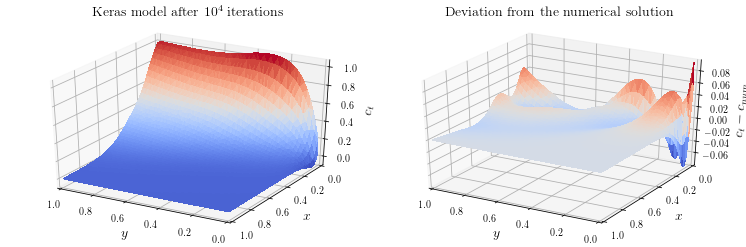

In [44]:
evaluation_points = np.column_stack((field50.x, field50.y))
model.load_weights("keras/best_baseline_weights.hdf5")
pred = model.predict(evaluation_points)
plot_field_and_error(field50.x, field50.y, pred[:,0], field50.A, "kerasBaselineFinal.pdf",
                     [r"Keras model after $10^4$ iterations", "Deviation from the numerical solution"])

### Comparison of error norms

In [43]:
baselineMLP = SimpleMLP(name='baselineMLPFinal', number_of_inputs=2, neurons_per_layer=5, hidden_layers=1)
customModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
customModel.mlp.read_weights_from_disk("./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy")
evaluation_points = np.column_stack((field100.x, field100.y))
l2_norm = customModel.l2_norm(evaluation_points, field100.A)
lmax_norm = customModel.lmax_norm(evaluation_points, field100.A)
print("Custom function approach: ")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)

pureNetworkModel = CustomFunctionLearning(name="customFunctionLearningAdaptive", mlp=baselineMLP, training_data=field50.A, beta=25.0, d_v=0.025)
pureNetworkModel.mlp.read_weights_from_disk("./pureNetworkLearningNoP/baselineMLPFinal/best_weights.npy")
l2_norm = pureNetworkModel.l2_norm(evaluation_points, field100.A)
lmax_norm = pureNetworkModel.lmax_norm(evaluation_points, field100.A)
print("Pure network approach: ")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)

model.load_weights("keras/best_baseline_weights.hdf5")
pred = model.predict(evaluation_points)
diff = pred[:, 0] - field100.A
l2_norm = np.dot(diff, diff) / len(diff)
lmax_norm = np.max(np.abs(diff))
print("Keras network: ")
print("L2 norm: ", l2_norm)
print("Lmax norm: ", lmax_norm)


Initialized weights and biases for MLP with 20 parameters.

MLP structure:
--------------
Input features:    2
Hidden layers:     1
Neurons per layer: 5
Number of weights: 20
Loaded weights from file ./customFunctionLearningAdaptive/baselineMLPFinal/best_weights.npy
Custom function approach: 
L2 norm:  5.203213057741802e-05
Lmax norm:  0.04697858781034808
Loaded weights from file ./pureNetworkLearningNoP/baselineMLPFinal/best_weights.npy
Pure network approach: 
L2 norm:  0.0073110046045390155
Lmax norm:  0.9996581595886426
Keras network: 
L2 norm:  0.00010534950473501825
Lmax norm:  0.11197767443802456
